In [491]:
import nltk, re, math
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import sys, os
sys.path.append(os.path.abspath(os.path.join('../../functions/')))

import prep_functions
fetcher = prep_functions.ExchangeRateFetcher('KRW')

In [492]:
origin_india_df = pd.read_csv('../../data/amazon.csv')
india_df = pd.read_csv('../../data/amazon_india.csv')
canada_df = pd.read_csv('../../data/amazon_canada.csv')
uk_df = pd.read_csv('../../data/amazon_uk.csv')
usa_df = pd.read_csv('../../data/amazon_usa.csv')

In [493]:
# price 관련 컬럼 수정
price_cols = ['discounted_price', 'actual_price']
origin_india_df[price_cols] = origin_india_df[price_cols].replace({'₹': '', ',': ''}, regex=True).astype(float)
origin_india_df['discount_percentage'] = origin_india_df['discount_percentage'].replace('%', '', regex=True).astype(float)

In [494]:
# rating 관련 컬럼 수정
origin_india_df = origin_india_df[origin_india_df['rating_count'].notnull()]
origin_india_df = origin_india_df.reset_index().drop(columns=('index'))
origin_india_df.loc[origin_india_df['rating'].str.contains('|', regex=False), 'rating'] = 3.8

In [495]:
def drop_price(df):
    df.drop(columns=['discounted_price','actual_price'], inplace=True)
    
drop_price(india_df)
drop_price(canada_df)
drop_price(usa_df)
uk_df.drop(columns=['discounted_price'], inplace=True)

In [496]:
# price 통화 변경
def convert_currency(row, col):
    if row[col] == 0:
        return 0
    return fetcher.convert(row[col], 'INR', 'KRW')

origin_india_df['discounted_price_KRW'] = origin_india_df.apply(lambda row: convert_currency(row, 'discounted_price'), axis=1).astype(int)
origin_india_df['actual_price_KRW'] = origin_india_df.apply(lambda row: convert_currency(row, 'actual_price'), axis=1).astype(int)

In [497]:
origin_india_df['rating'] = origin_india_df['rating'].astype(float)
origin_india_df['rating_count'] = origin_india_df['rating_count'].str.replace(',','').astype(int)
origin_india_df = origin_india_df.drop_duplicates(subset=['product_id', 'product_name', 'discounted_price_KRW', 'actual_price_KRW'], keep='last')

In [498]:
# 카테고리 추가
# origin_india_df.loc[:, 'big_category'] = origin_india_df['category'].apply(lambda x: x.split('|')[0])
origin_india_df.loc[:, 'category'] = origin_india_df['category'].apply(lambda x: x.split('|')[-2])

In [499]:
origin_india_df.head(2)

product_id                                       product_name  \
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
8  B008IFXQFU  TP-Link USB WiFi Adapter for PC(TL-WN725N), N1...   

          category  discounted_price  actual_price  discount_percentage  \
2           Cables             199.0        1899.0                 90.0   
8  NetworkAdapters             499.0         999.0                 50.0   

   rating  rating_count                                      about_product  \
2     3.9          7928  【 Fast Charger& Data Sync】-With built-in safet...   
8     4.2        179691  USB WiFi Adapter —— Speedy wireless transmissi...   

                                             user_id  \
2  AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...   
8  AGV3IEFANZCKECFGUM42MRH5FNOA,AEBO7NWCNXKT4AESA...   

                                           user_name  \
2  Kunal,Himanshu,viswanath,sai niharka,saqib mal...   
8  Azhar JuMan,Anirudh Sood,Hari Krishnan PS,Akas...   

                                           review_id  \
2  R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...   
8  R1LW6NWSVTVZ2H,R3VR5WFKUS15C5,R2F6GC79OYWUKQ,R...   

                                        review_title  \
2  Good speed for earlier versions,Good Product,W...   
8  Works on linux for me. Get the model with ante...   

                                      review_content  \
2  Not quite durable and sturdy,https://m.media-a...   
8  I use this to connect an old PC to internet. I...   

                                            img_link  \
2  https://m.media-amazon.com/images/W/WEBP_40237...   
8  https://m.media-amazon.com/images/W/WEBP_40237...   

                                        product_link  discounted_price_KRW  \
2  https://www.amazon.in/Sounce-iPhone-Charging-C...                  3262   
8  https://www.amazon.in/TP-Link-TL-WN725N-150Mbp...                  8180   

   actual_price_KRW  
2             31131  
8             16377

---

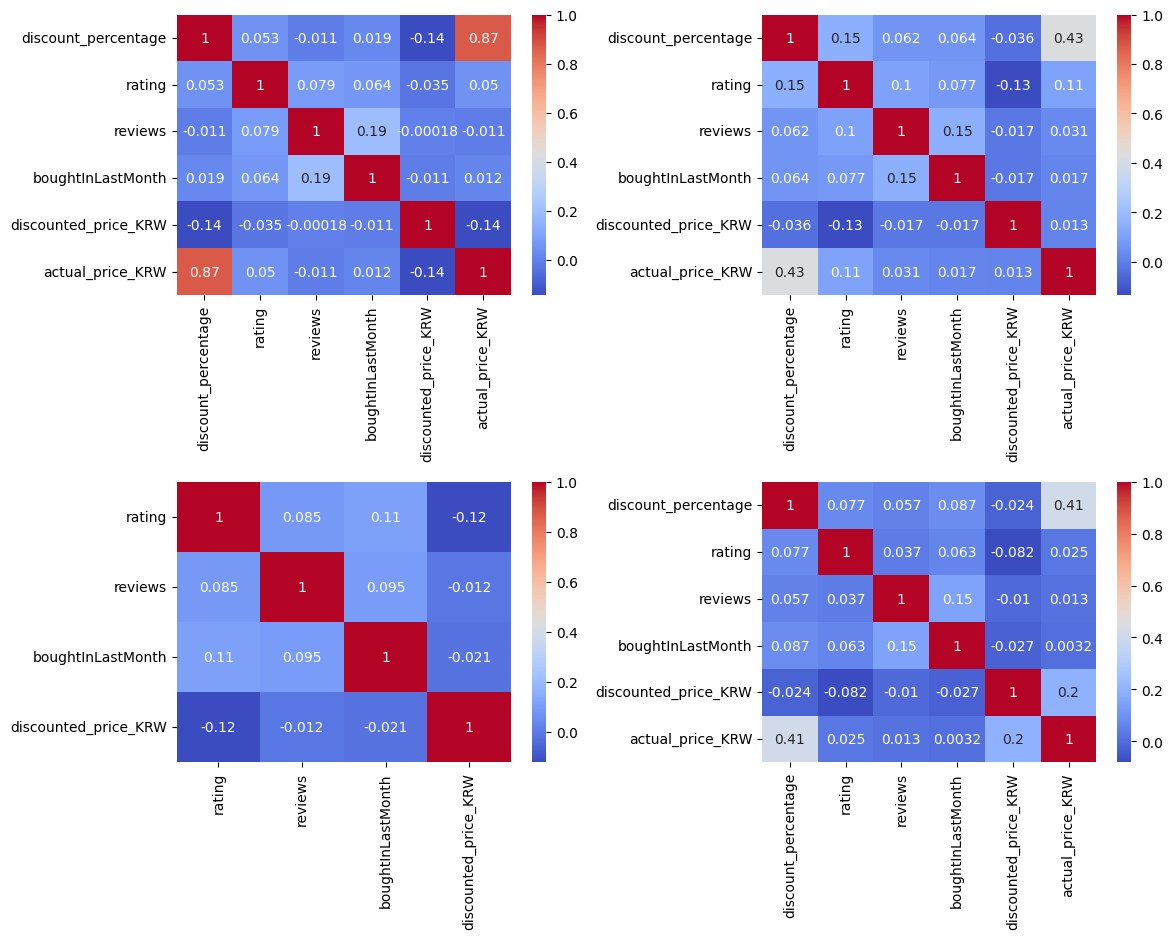

In [457]:
# 상관계수
def numeric(dfs):
    num_dfs = [df.select_dtypes(include=['number']) for df in dfs]
    return check_corr(num_dfs)

def check_corr(dfs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for ax, df in zip(axes.flat, dfs):
        corr = df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

numeric([india_df, canada_df, uk_df, usa_df])

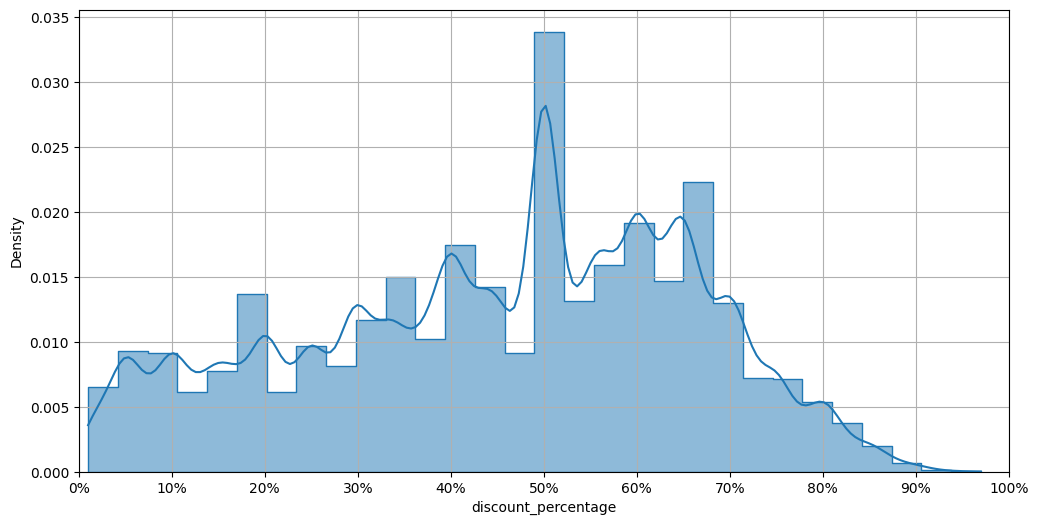

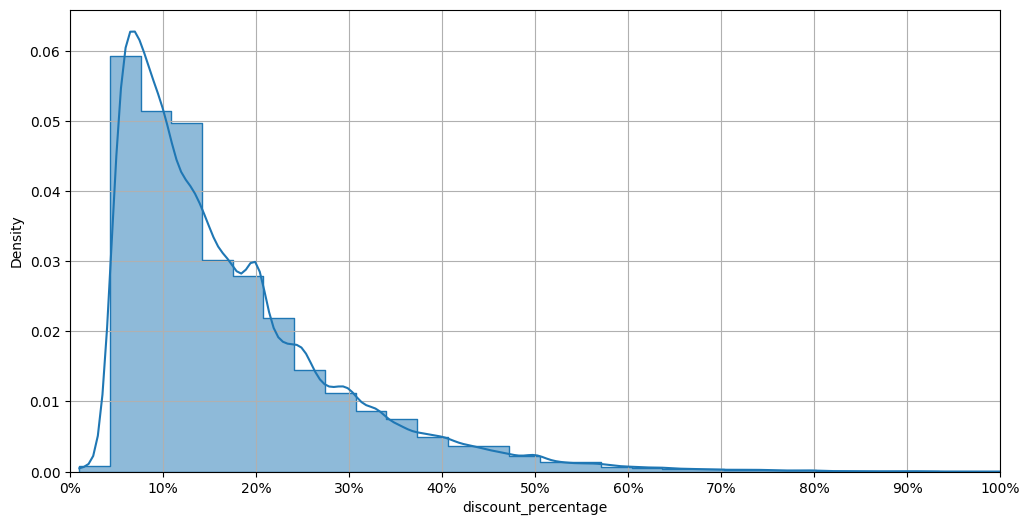

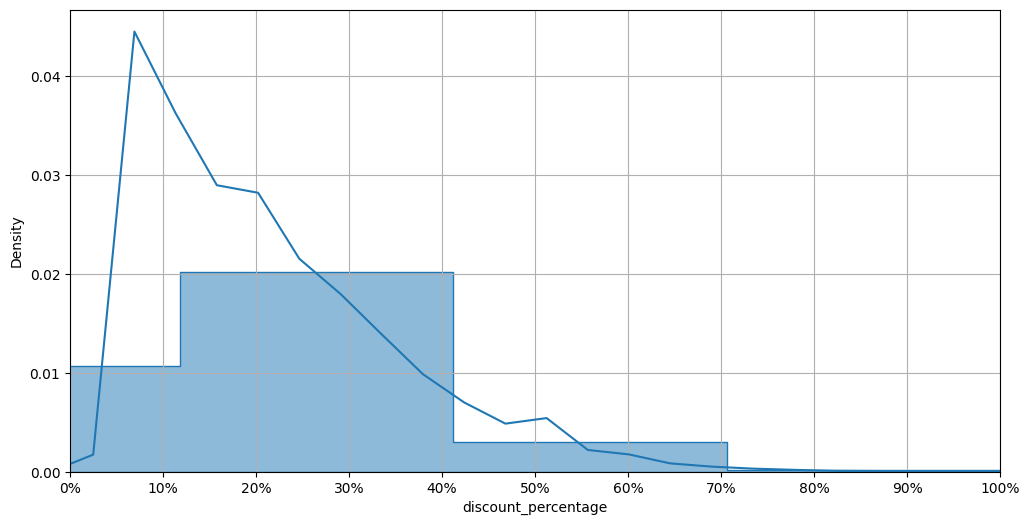

In [458]:
# 할인율 0인 데이터 제외, 할인율 빈도
def filter_zero_pc(dfs):
    filtered = [df.query('discount_percentage != 0') for df in dfs]
    discounted_pc_histogram(filtered)
    
def discounted_pc_histogram(dfs):
    for df in dfs:
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='discount_percentage', bins=30, kde=True, stat='density', element='step')
        
        plt.xlim(0, 100)
        ticks = range(0, 101, 10)
        plt.xticks(ticks, [f'{tick}%' for tick in ticks])
        plt.grid()
        plt.show()
        
filter_zero_pc([india_df, canada_df, usa_df])

----

In [500]:
countries = ['India', 'Canada', 'UK', 'USA']

def elbow_graph(dfs):
    numeric_columns = ['discounted_price_KRW', 'rating', 'reviews']
    # dfs = [df[numeric_columns].query('discounted_price_KRW != 0') for df in dfs]
    dfs = [df[numeric_columns] for df in dfs]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for i, df in enumerate(dfs):
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)

        inertia = []
        K = range(1, 10)
        for k in K:
            kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
            kmeans.fit(df_scaled)
            inertia.append(kmeans.inertia_)
        axes[i].plot(K, inertia, 'bx-')
        axes[i].set_title(f'{countries[i]}')
        
    plt.tight_layout()
    plt.show()

def price_rating_reviews_kmeans_clustering(dfs, n_clusters=4):
    result = []
    numeric_columns = ['discounted_price_KRW', 'rating', 'reviews']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, df in enumerate(dfs):
        # df = df.query('discounted_price_KRW != 0')
        
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df[numeric_columns])

        pca = PCA(n_components=2)
        df_pca = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(data=df_pca, columns=['PCA1', 'PCA2'])
        
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
        pca_df['cluster'] = kmeans.fit_predict(df_scaled)
        df['cluster'] = kmeans.fit_predict(df_scaled)

        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', 
                        palette='viridis', alpha=0.7, ax=axes[i])

        axes[i].set_title(f'PCA K-means Clustering for {countries[i]}')
        axes[i].set_xlabel('PCA Component 1')
        axes[i].set_ylabel('PCA Component 2')
        axes[i].set_xlim(-5, 10)
        axes[i].set_ylim(-5, 10)
        
        result.append(df)
        
    plt.tight_layout()
    plt.show()
    
    return result

In [501]:
def elbow_graph2(dfs):
    numeric_columns = ['discounted_price_KRW', 'rating', 'rating_count']
    # dfs = [df[numeric_columns].query('discounted_price_KRW != 0') for df in dfs]
    dfs = [df[numeric_columns] for df in dfs]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for i, df in enumerate(dfs):
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)

        inertia = []
        K = range(1, 10)
        for k in K:
            kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
            kmeans.fit(df_scaled)
            inertia.append(kmeans.inertia_)
        axes[i].plot(K, inertia, 'bx-')
        axes[i].set_title(f'india')
        
    plt.tight_layout()
    plt.show()

def price_rating_reviews_kmeans_clustering2(dfs, n_clusters=3):
    result = []
    numeric_columns = ['discounted_price_KRW', 'rating', 'rating_count']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, df in enumerate(dfs):
        # df = df.query('discounted_price_KRW != 0')
        
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df[numeric_columns])

        pca = PCA(n_components=2)
        df_pca = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(data=df_pca, columns=['PCA1', 'PCA2'])
        
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
        pca_df['cluster'] = kmeans.fit_predict(df_scaled)
        df['cluster'] = kmeans.fit_predict(df_scaled)

        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', 
                        palette='viridis', alpha=0.7, ax=axes[i])

        axes[i].set_title(f'PCA K-means Clustering for india')
        axes[i].set_xlabel('PCA Component 1')
        axes[i].set_ylabel('PCA Component 2')
        axes[i].set_xlim(-5, 10)
        axes[i].set_ylim(-5, 10)
        
        result.append(df)
        
    plt.tight_layout()
    plt.show()
    
    return result

In [502]:
# india_df = india_df[(india_df['discounted_price_KRW'] != 0) & (india_df['actual_price_KRW'] != 0)]
canada_df = canada_df[(canada_df['discounted_price_KRW'] != 0) & (canada_df['actual_price_KRW'] != 0)]
usa_df = usa_df[
    (usa_df['discounted_price_KRW'] != 0) & 
    (usa_df['actual_price_KRW'] != 0) & 
    (usa_df['discounted_price_KRW'] < usa_df['actual_price_KRW'])
]
uk_df = uk_df[uk_df['discounted_price_KRW'] != 0]

In [503]:
# 카테고리별 개수 체크
def check_category_count(dfs):
    for i, df in enumerate(dfs):
        category_count = df['category'].value_counts().reset_index()
        category_percentage = df['category'].value_counts(normalize=True).reset_index()
        
        category_count.columns = ['category', 'count']
        category_percentage.columns = ['category', 'percentage']
        category_stats_df = pd.merge(category_count, category_percentage, on='category')
        
        category_stats_df['percentage'] = round(category_stats_df['percentage'] * 100, 2)
        
        display(category_stats_df)

In [504]:
country = [origin_india_df, canada_df, uk_df, usa_df]
countries = ['india','canada', 'uk', 'usa']

check_category_count(country)

category  count  percentage
0                     Cables    191       14.12
1     SmallKitchenAppliances    137       10.13
2   Smartphones&BasicMobiles     77        5.69
3                Televisions     66        4.88
4         WearableTechnology     64        4.73
..                       ...    ...         ...
95          PowerAccessories      1        0.07
96            CraftMaterials      1        0.07
97                   Laptops      1        0.07
98                     Décor      1        0.07
99                VacuumBags      1        0.07

[100 rows x 3 columns]

category  count  percentage
0                            Electronics   3969        2.38
1                                 Beauty   3819        2.29
2                   Luggage  Travel Gear   3112        1.87
3                                  Women   2896        1.74
4                                    Men   2356        1.41
..                                   ...    ...         ...
256           Blu-ray Players  Recorders      2        0.00
257              Toy Gardening Equipment      2        0.00
258                Scaffolding Equipment      2        0.00
259                 Handmade Toys  Games      1        0.00
260  Handmade Stationery  Party Supplies      1        0.00

[261 rows x 3 columns]

category   count  percentage
0                 Sports & Outdoors  826072       37.16
1                         Skin Care   18755        0.84
2                        Fragrances   18563        0.84
3                           Make-up   18453        0.83
4      Manicure & Pedicure Products   17212        0.77
..                              ...     ...         ...
291                         Torches      64        0.00
292  Smart Home Security & Lighting      57        0.00
293                        Lighting      50        0.00
294                  Smart Speakers      25        0.00
295                         Cameras      12        0.00

[296 rows x 3 columns]

category  count  percentage
0                                       Men's Shoes   7544        2.19
1                                      Toys & Games   6630        1.92
2                                     Women's Shoes   6320        1.83
3                                  Women's Clothing   6015        1.74
4                                   Girls' Clothing   5790        1.68
..                                              ...    ...         ...
242           Smart Home: Voice Assistants and Hubs     10        0.00
243                   Smart Home: New Smart Devices     10        0.00
244                                    Garment Bags      5        0.00
245  Smart Home Thermostats - Compatibility Checker      3        0.00
246                      Online Video Game Services      1        0.00

[247 rows x 3 columns]

In [505]:
# uk category : Sports & Outdoors 샘플링
def undersample_sports_and_outdoors_to_second_largest(uk_df):
    # 샘플링 개수
    category_counts = uk_df['category'].value_counts()
    second_largest_count = category_counts.nlargest(2).iloc[-1]
    
    category_data = uk_df[uk_df['category'] == 'Sports & Outdoors']
    category_data = category_data.sample(n=second_largest_count, random_state=42)
    
    other_data = uk_df[uk_df['category'] != 'Sports & Outdoors']
    undersampled_uk_df = pd.concat([category_data, other_data], ignore_index=True)
    
    return undersampled_uk_df

uk_df = undersample_sports_and_outdoors_to_second_largest(uk_df)

In [506]:
country = [canada_df, uk_df, usa_df]

check_category_count(country)

category  count  percentage
0                            Electronics   3969        2.38
1                                 Beauty   3819        2.29
2                   Luggage  Travel Gear   3112        1.87
3                                  Women   2896        1.74
4                                    Men   2356        1.41
..                                   ...    ...         ...
256           Blu-ray Players  Recorders      2        0.00
257              Toy Gardening Equipment      2        0.00
258                Scaffolding Equipment      2        0.00
259                 Handmade Toys  Games      1        0.00
260  Handmade Stationery  Party Supplies      1        0.00

[261 rows x 3 columns]

category  count  percentage
0                 Sports & Outdoors  18755        1.33
1                         Skin Care  18755        1.33
2                        Fragrances  18563        1.31
3                           Make-up  18453        1.30
4      Manicure & Pedicure Products  17212        1.22
..                              ...    ...         ...
291                         Torches     64        0.00
292  Smart Home Security & Lighting     57        0.00
293                        Lighting     50        0.00
294                  Smart Speakers     25        0.00
295                         Cameras     12        0.00

[296 rows x 3 columns]

category  count  percentage
0                                       Men's Shoes   7544        2.19
1                                      Toys & Games   6630        1.92
2                                     Women's Shoes   6320        1.83
3                                  Women's Clothing   6015        1.74
4                                   Girls' Clothing   5790        1.68
..                                              ...    ...         ...
242           Smart Home: Voice Assistants and Hubs     10        0.00
243                   Smart Home: New Smart Devices     10        0.00
244                                    Garment Bags      5        0.00
245  Smart Home Thermostats - Compatibility Checker      3        0.00
246                      Online Video Game Services      1        0.00

[247 rows x 3 columns]

In [507]:
def filter_category(dfs):
    filtered_dfs = []

    for df in dfs:
        category_counts = df['category'].value_counts().reset_index()
        category_counts.columns = ['category', 'count']
        max_count = category_counts['count'].max()
        
        threshold = max_count * 0.1
        filtered_categories = category_counts[category_counts['count'] >= threshold]['category']
        filtered_df = df[df['category'].isin(filtered_categories)]
        filtered_dfs.append(filtered_df)

    return filtered_dfs

f_country = filter_category(country)

In [508]:
check_category_count(f_country)

category  count  percentage
0                     Electronics   3969        2.62
1                          Beauty   3819        2.52
2            Luggage  Travel Gear   3112        2.05
3                           Women   2896        1.91
4                             Men   2356        1.55
..                            ...    ...         ...
143         Coffee, Tea  Espresso    442        0.29
144  Abrasive  Finishing Products    420        0.28
145       Power Tools  Hand Tools    412        0.27
146              Backyard Birding    406        0.27
147            Household Supplies    402        0.27

[148 rows x 3 columns]

category  count  percentage
0                 Sports & Outdoors  18755        1.37
1                         Skin Care  18755        1.37
2                        Fragrances  18563        1.35
3                           Make-up  18453        1.35
4      Manicure & Pedicure Products  17212        1.26
..                              ...    ...         ...
170          Made in Italy Handmade   2152        0.16
171    Home Entertainment Furniture   2091        0.15
172           Home Office Furniture   2027        0.15
173  Women's Sports & Outdoor Shoes   1958        0.14
174                    Ski Clothing   1908        0.14

[175 rows x 3 columns]

category  count  percentage
0                Men's Shoes   7544        2.36
1               Toys & Games   6630        2.07
2              Women's Shoes   6320        1.98
3           Women's Clothing   6015        1.88
4            Girls' Clothing   5790        1.81
..                       ...    ...         ...
157        Computer Monitors    792        0.25
158     Kids' Party Supplies    780        0.24
159       Household Supplies    770        0.24
160  Diet & Sports Nutrition    762        0.24
161        Kids' Electronics    759        0.24

[162 rows x 3 columns]

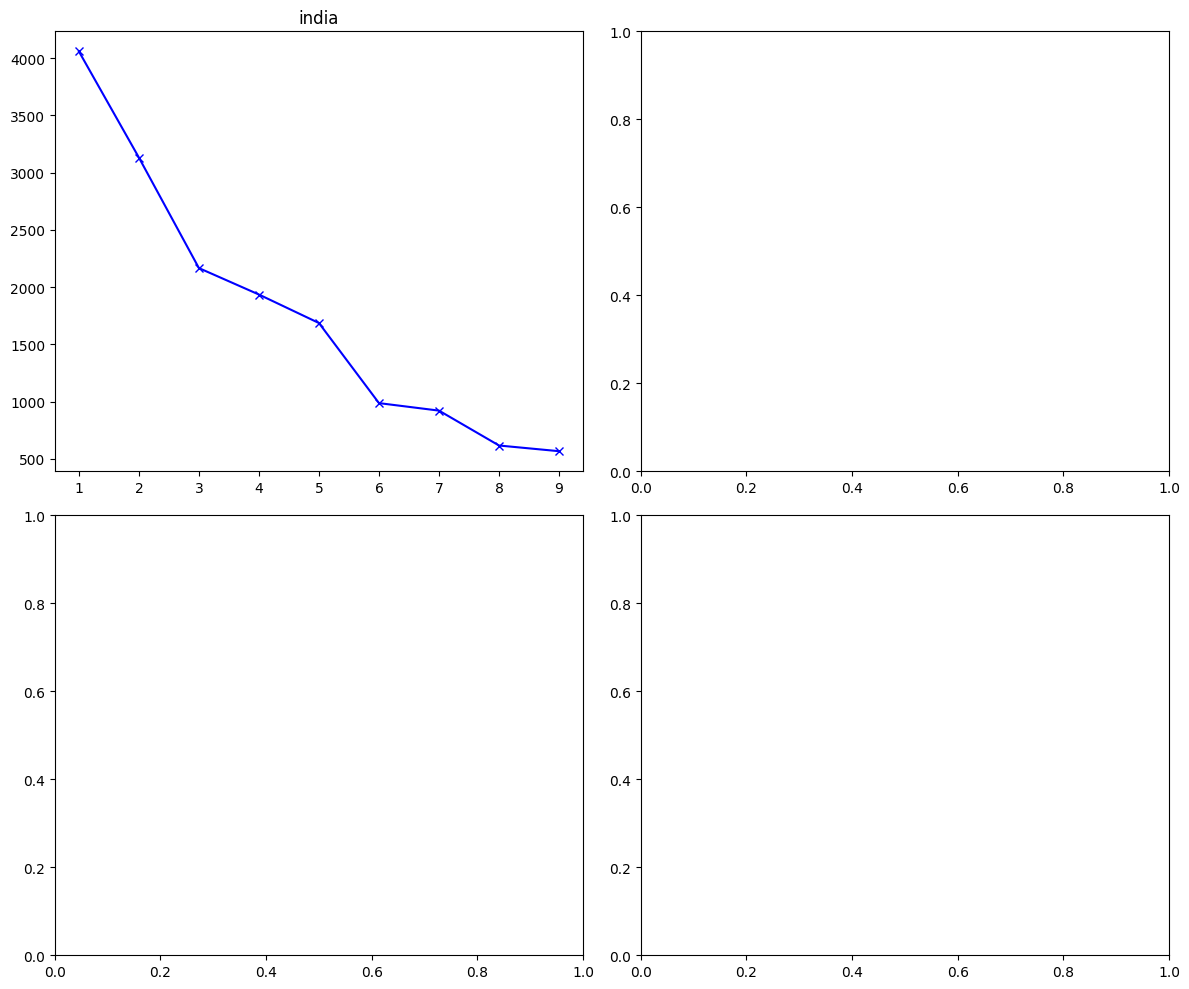

In [471]:
elbow_graph2([origin_india_df])

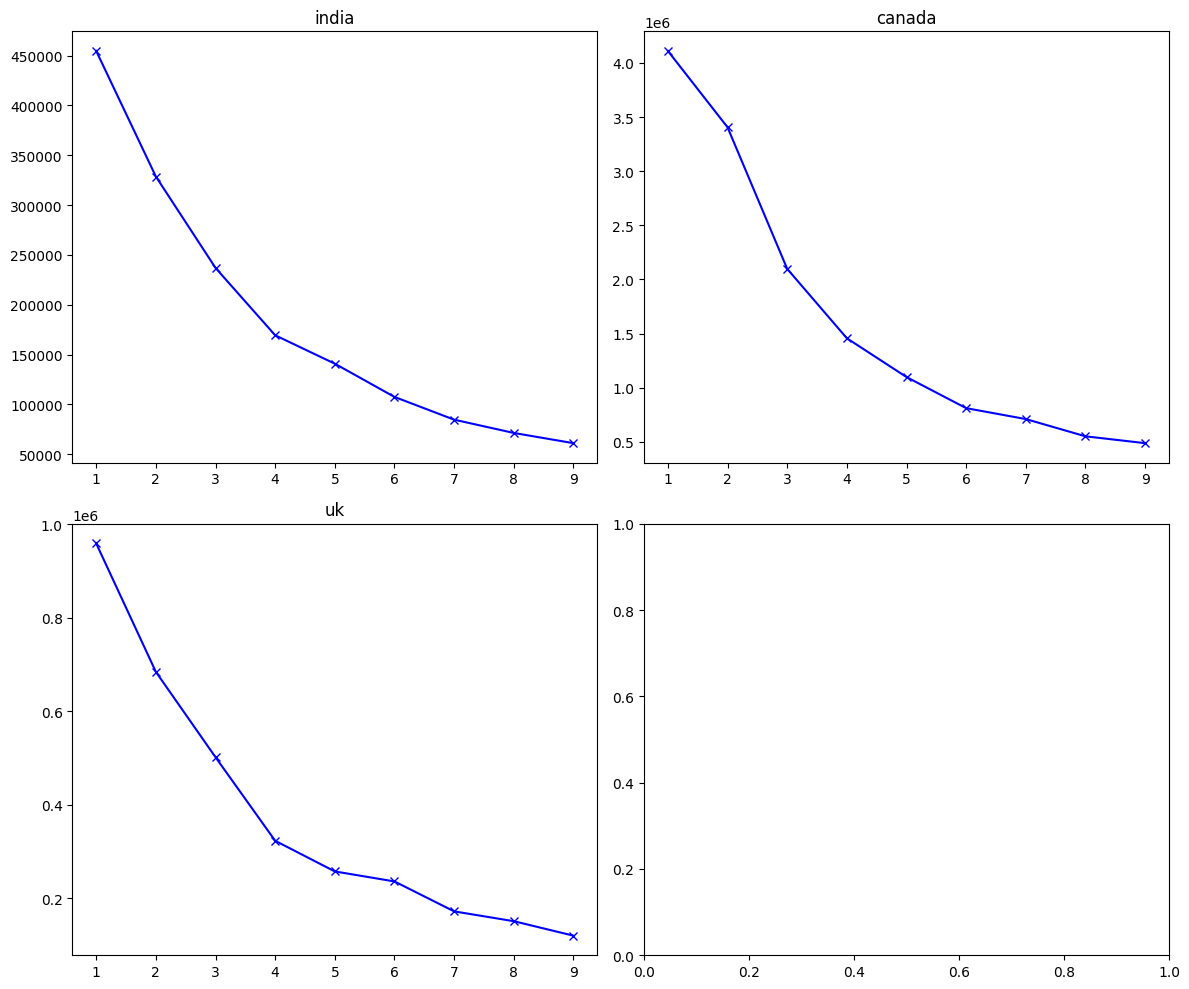

In [509]:
elbow_graph(f_country)

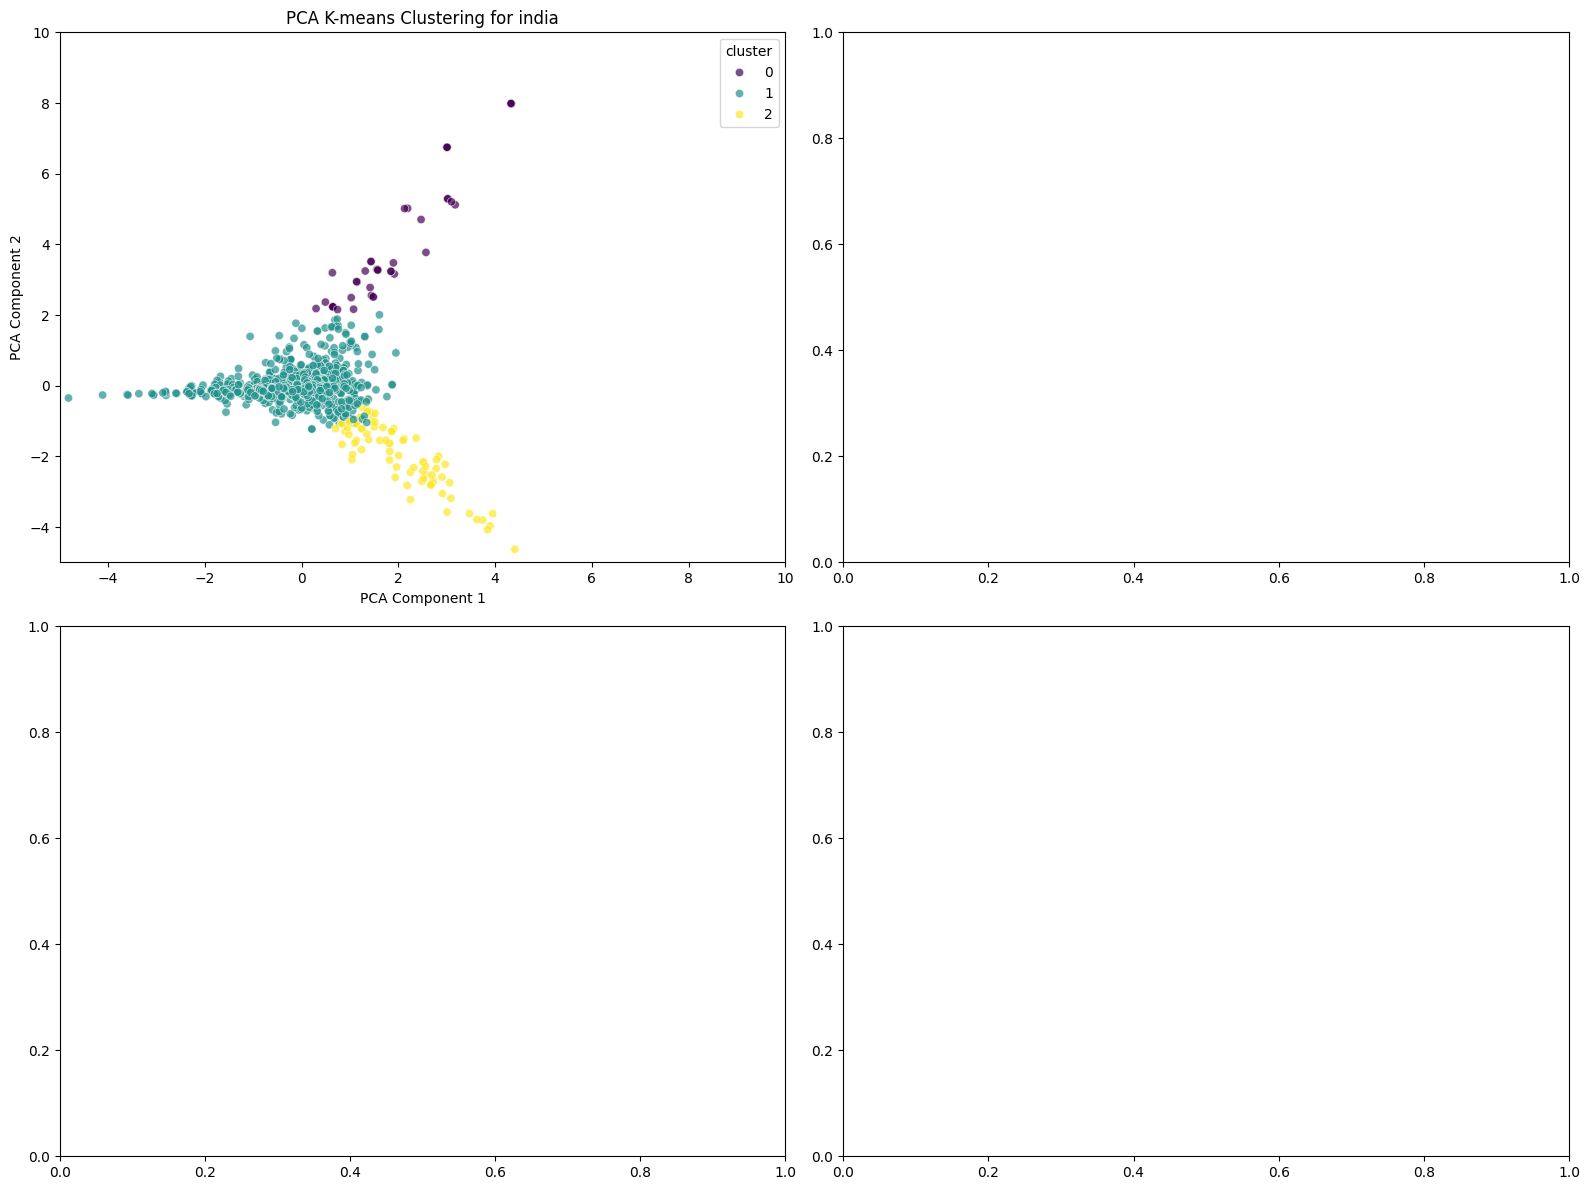

In [510]:
india_cluster_dfs = price_rating_reviews_kmeans_clustering2([origin_india_df])

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3740635338.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(df_scaled)
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3740635338.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(df_scaled)
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3740635338.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

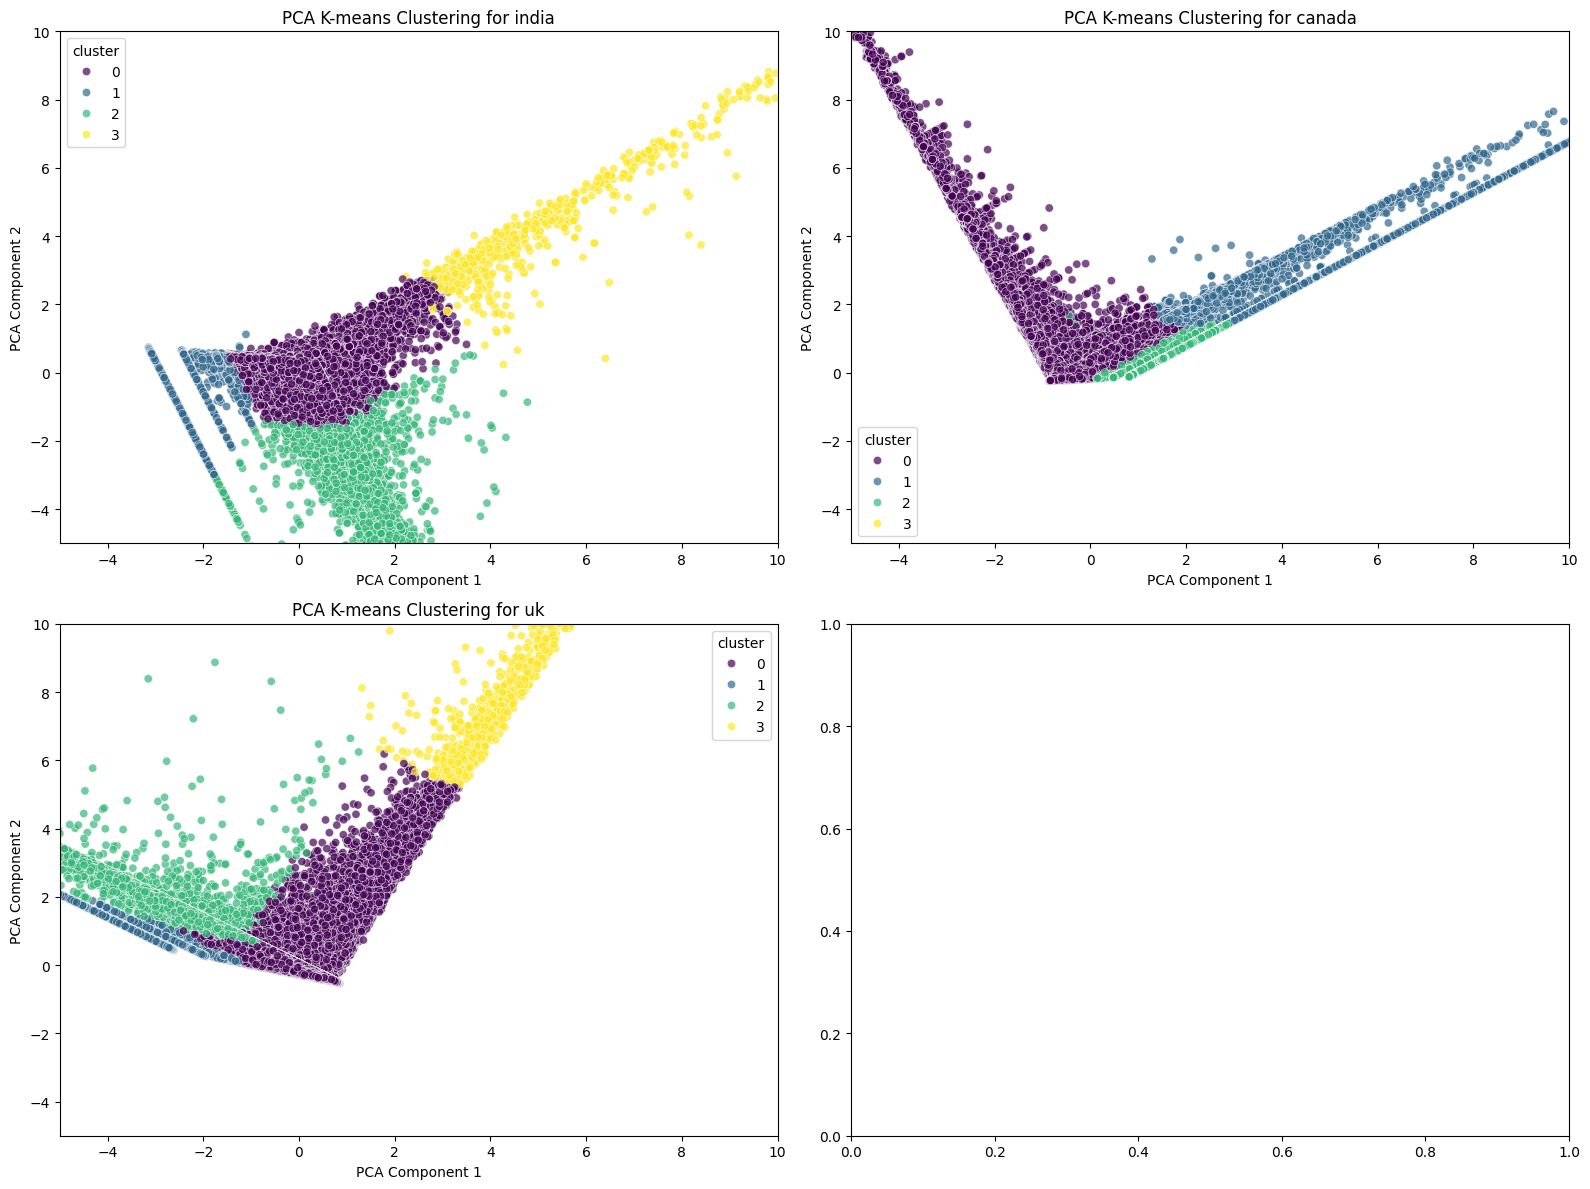

In [511]:
cluster_dfs = price_rating_reviews_kmeans_clustering(f_country)

In [512]:
def analyze_clusters(dfs, column_name):
    for i, df in enumerate(dfs):
        # 클러스터 분석
        cluster_analysis = df.groupby('cluster')[column_name].value_counts(normalize=True).unstack()
        
        # 히트맵 그리기
        plt.figure(figsize=(10, 7))
        sns.heatmap(cluster_analysis, cmap='YlGnBu')  # 히트맵 내부 글자 끔
        plt.title(f'Distribution of {column_name} across clusters for {countries[i]}')
        plt.show()
        
        # 클러스터별 상위 5개 카테고리 출력
        for cluster in cluster_analysis.index:
            top_5_categories = cluster_analysis.loc[cluster].nlargest(5)
            print(f"Cluster {cluster} - Top 5 {column_name} for {countries[i]}:\n", top_5_categories)
            print("-" * 50)

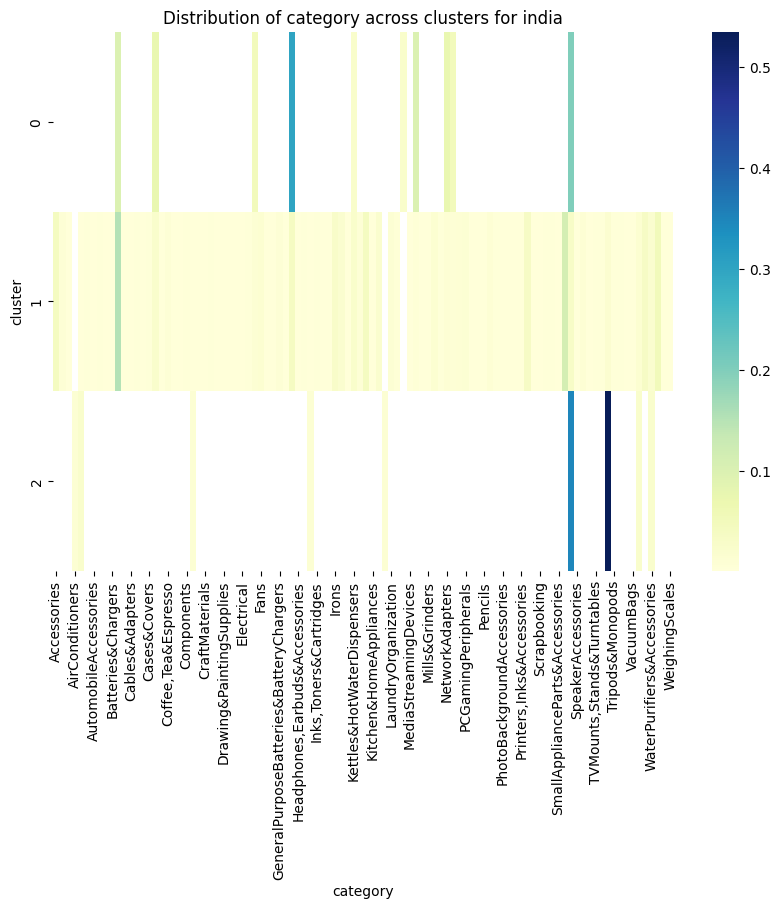

Cluster 0 - Top 5 category for india:
 category
Headphones                  0.300
Smartphones&BasicMobiles    0.200
Cables                      0.100
MemoryCards                 0.100
Chargers                    0.075
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for india:
 category
Cables                         0.152404
SmallKitchenAppliances         0.111654
WearableTechnology             0.052160
Accessories                    0.042380
Keyboards,Mice&InputDevices    0.040750
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for india:
 category
Televisions                   0.534884
Smartphones&BasicMobiles      0.348837
AirPurifiers                  0.023256
Vacuums                       0.023256
WaterPurifiers&Accessories    0.023256
Name: 2, dtype: float64
--------------------------------------------------


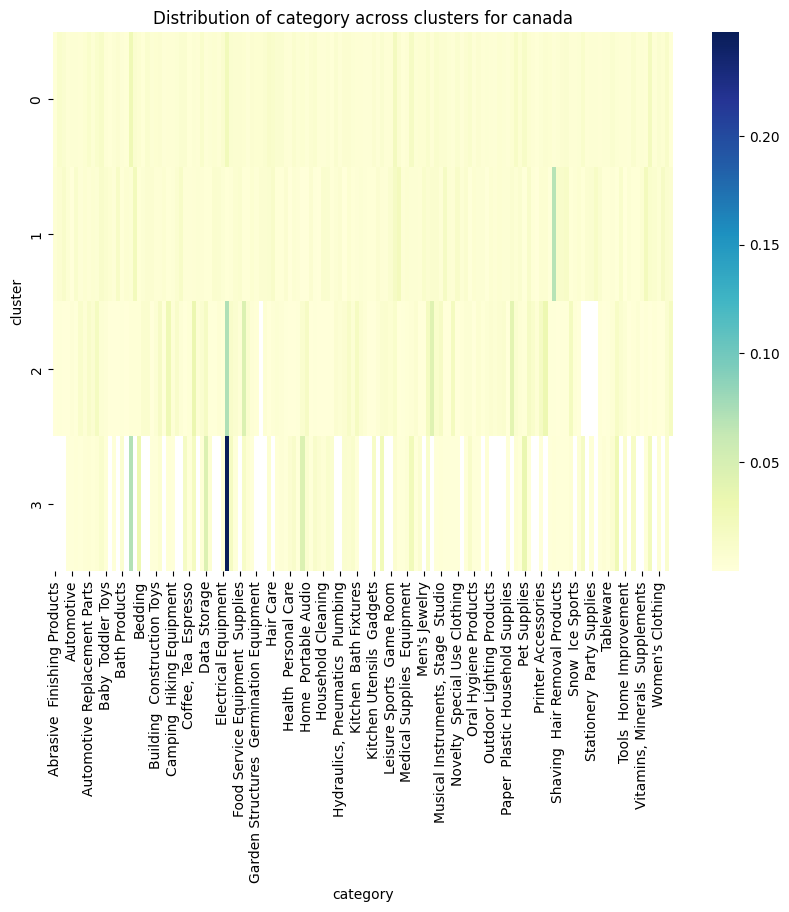

Cluster 0 - Top 5 category for canada:
 category
Beauty                  0.027470
Electronics             0.023997
Luggage  Travel Gear    0.021320
Women                   0.020643
Men                     0.016762
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for canada:
 category
Sex  Sensuality Products     0.069670
Beauty Tools  Accessories    0.022967
Makeup                       0.022198
Wellness                     0.022088
Luggage  Travel Gear         0.017363
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for canada:
 category
Electronics                     0.072200
Furniture                       0.045983
Men's Watches                   0.043460
Patio Furniture  Accessories    0.039114
Computer Components             0.032244
Name: 2, dtype: float64
--------------------------------------------------
Cluster 3 - Top 5 category for canada:
 category
Electronics      0.

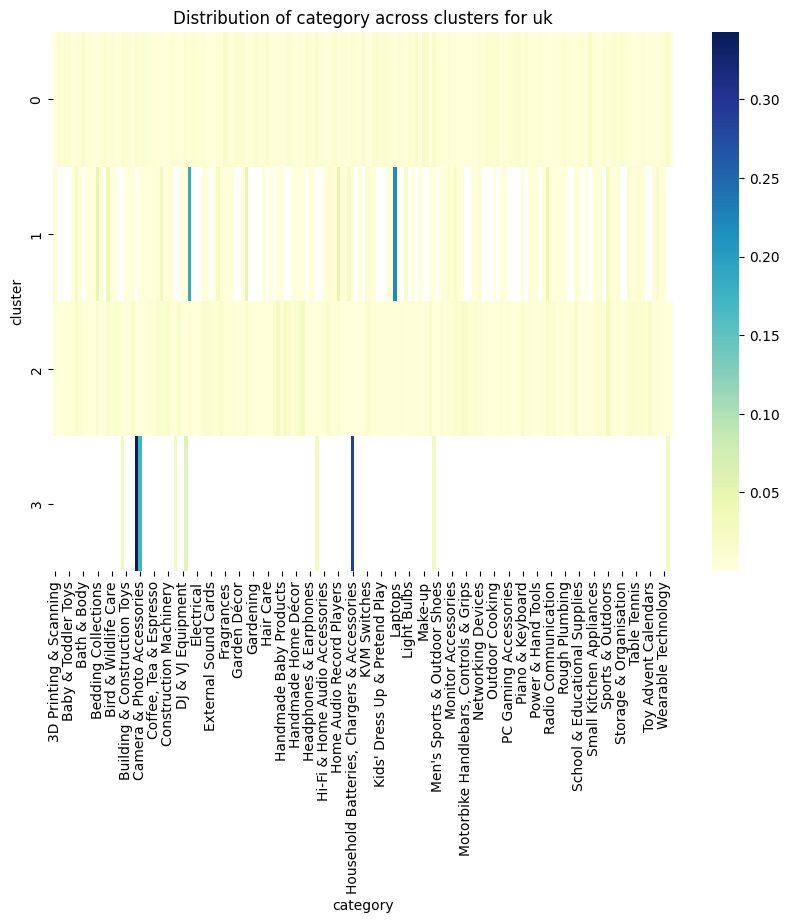

Cluster 0 - Top 5 category for uk:
 category
Skin Care     0.020521
Make-up       0.019170
Men           0.018436
Women         0.018353
Fragrances    0.017777
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for uk:
 category
Laptops                      0.220260
Desktop PCs                  0.185528
Garden Storage & Housing     0.051635
Bedding Collections          0.048741
Home Audio Record Players    0.048509
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for uk:
 category
Sports & Outdoors                         0.031344
Handmade Clothing, Shoes & Accessories    0.027907
Handmade Kitchen & Dining                 0.026720
Handmade Artwork                          0.026123
Handmade Jewellery                        0.018344
Name: 2, dtype: float64
--------------------------------------------------
Cluster 3 - Top 5 category for uk:
 category
Cables & Accessories               

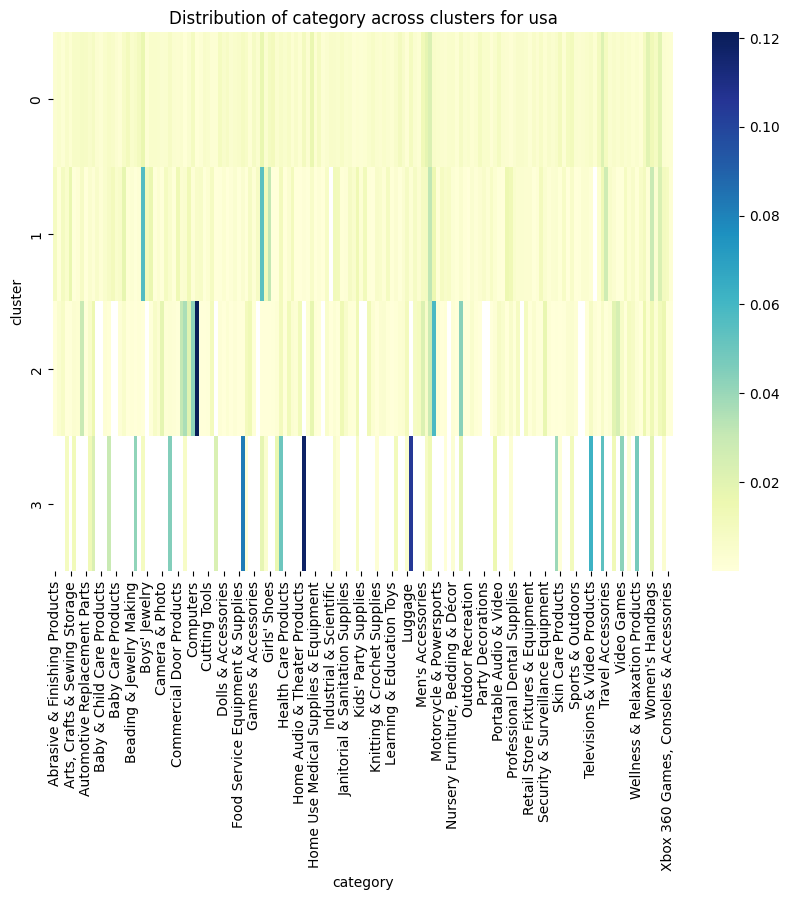

Cluster 0 - Top 5 category for usa:
 category
Men's Shoes         0.023066
Toys & Games        0.021454
Women's Clothing    0.020226
Women's Shoes       0.019937
Men's Clothing      0.018312
Name: 0, dtype: float64
--------------------------------------------------
Cluster 1 - Top 5 category for usa:
 category
Boys' Clothing      0.056517
Girls' Clothing     0.054335
Men's Shoes         0.031859
Girls' Shoes        0.031495
Women's Handbags    0.029604
Name: 1, dtype: float64
--------------------------------------------------
Cluster 2 - Top 5 category for usa:
 category
Computers & Tablets    0.121278
Men's Watches          0.058568
Office Electronics     0.043384
Computers              0.042497
Computer Monitors      0.036088
Name: 2, dtype: float64
--------------------------------------------------
Cluster 3 - Top 5 category for usa:
 category
Home Décor Products                0.117750
Makeup                             0.104569
Foot, Hand & Nail Care Products    0.081722
Televisio

In [513]:
cluster_dfs = india_cluster_dfs + f_country

analyze_clusters(cluster_dfs, 'category')

In [514]:
def cluster_profiles_integration(dfs, column_name):
    data = []
    
    for i, df in enumerate(dfs):
        # Iterate over each cluster
        for cluster in df['cluster'].unique():
            cluster_data = df[df['cluster'] == cluster]
            
            # Top categories (빈도 상위 5개 카테고리)
            top_cats = cluster_data[column_name].value_counts(normalize=True).head(5)
            top_cats_dict = {f"top_category_{i+1}": f"{cat} ({pct:.2%})" 
                             for i, (cat, pct) in enumerate(top_cats.items())}
            
            # Combine all information
            cluster_profile = {'country': countries[i], 'cluster': cluster, **top_cats_dict}
            data.append(cluster_profile)
    
    # Create DataFrame
    profiles_df = pd.DataFrame(data)
    profiles_df.set_index(['country', 'cluster'], inplace=True)
    profiles_df = profiles_df.sort_index(level=['country', 'cluster'])
    
    return profiles_df


def cluster_profiles_division(dfs, column_name):
    country_dfs = {}
    
    for i, df in enumerate(dfs):
        data = []
        
        # Iterate over each cluster
        for cluster in df['cluster'].unique():
            cluster_data = df[df['cluster'] == cluster]
            
            # Top categories (빈도 상위 5개 카테고리)
            top_cats = cluster_data[column_name].value_counts(normalize=True).head(5)
            top_cats_dict = {f"top_category_{i+1}": f"{cat} ({pct:.2%})" 
                             for i, (cat, pct) in enumerate(top_cats.items())}
            
            # Combine all information
            cluster_profile = {'country': countries[i], 'cluster': cluster, **top_cats_dict}
            data.append(cluster_profile)
        
        # Create DataFrame for the current country
        profiles_df = pd.DataFrame(data)
        profiles_df.set_index(['country', 'cluster'], inplace=True)
        profiles_df = profiles_df.sort_index(level=['country', 'cluster'])
        
        # Store the DataFrame for each country
        country_dfs[countries[i]] = profiles_df
    
    return country_dfs

In [515]:
# 통합 df
profiles_df = cluster_profiles_integration(cluster_dfs, 'category')
display(profiles_df)

top_category_1  \
country cluster                                     
canada  0                          Beauty (2.75%)   
        1        Sex  Sensuality Products (6.97%)   
        2                     Electronics (7.22%)   
        3                    Electronics (24.76%)   
india   0                     Headphones (30.00%)   
        1                         Cables (15.24%)   
        2                    Televisions (53.49%)   
uk      0                       Skin Care (2.05%)   
        1                        Laptops (22.03%)   
        2               Sports & Outdoors (3.13%)   
        3           Cables & Accessories (34.29%)   
usa     0                     Men's Shoes (2.31%)   
        1                  Boys' Clothing (5.65%)   
        2            Computers & Tablets (12.13%)   
        3            Home Décor Products (11.78%)   

                                                    top_category_2  \
country cluster                                                      
canada  0                                      Electronics (2.40%)   
        1                        Beauty Tools  Accessories (2.30%)   
        2                                        Furniture (4.60%)   
        3                                           Beauty (7.14%)   
india   0                        Smartphones&BasicMobiles (20.00%)   
        1                          SmallKitchenAppliances (11.17%)   
        2                        Smartphones&BasicMobiles (34.88%)   
uk      0                                          Make-up (1.92%)   
        1                                     Desktop PCs (18.55%)   
        2           Handmade Clothing, Shoes & Accessories (2.79%)   
        3        Household Batteries, Chargers & Accessories (2...   
usa     0                                     Toys & Games (2.15%)   
        1                                  Girls' Clothing (5.43%)   
        2                                    Men's Watches (5.86%)   
        3                                          Makeup (10.46%)   

                                          top_category_3  \
country cluster                                            
canada  0                   Luggage  Travel Gear (2.13%)   
        1                                 Makeup (2.22%)   
        2                          Men's Watches (4.35%)   
        3                          Home  Kitchen (4.64%)   
india   0                                Cables (10.00%)   
        1                     WearableTechnology (5.22%)   
        2                           AirPurifiers (2.33%)   
uk      0                                    Men (1.84%)   
        1               Garden Storage & Housing (5.16%)   
        2              Handmade Kitchen & Dining (2.67%)   
        3            Camera & Photo Accessories (17.14%)   
usa     0                       Women's Clothing (2.02%)   
        1                            Men's Shoes (3.19%)   
        2                     Office Electronics (4.34%)   
        3        Foot, Hand & Nail Care Products (8.17%)   

                                       top_category_4  \
country cluster                                         
canada  0                               Women (2.06%)   
        1                            Wellness (2.21%)   
        2        Patio Furniture  Accessories (3.91%)   
        3                        Data Storage (4.52%)   
india   0                        MemoryCards (10.00%)   
        1                         Accessories (4.24%)   
        2          WaterPurifiers&Accessories (2.33%)   
uk      0                               Women (1.84%)   
        1                 Bedding Collections (4.87%)   
        2                    Handmade Artwork (2.61%)   
        3                        Data Storage (5.71%)   
usa     0                       Women's Shoes (1.99%)   
        1                        Girls' Shoes (3.15%)   
        2                           Computers (4.25%)   
        3

In [516]:
# country별 df
country_dfs = cluster_profiles_division(cluster_dfs, 'category')

for country, df in country_dfs.items():
    display(df)
    print("\n")

top_category_1                     top_category_2  \
country cluster                                                            
india   0         Headphones (30.00%)  Smartphones&BasicMobiles (20.00%)   
        1             Cables (15.24%)    SmallKitchenAppliances (11.17%)   
        2        Televisions (53.49%)  Smartphones&BasicMobiles (34.88%)   

                             top_category_3  \
country cluster                               
india   0                   Cables (10.00%)   
        1        WearableTechnology (5.22%)   
        2              AirPurifiers (2.33%)   

                                     top_category_4  \
country cluster                                       
india   0                      MemoryCards (10.00%)   
        1                       Accessories (4.24%)   
        2        WaterPurifiers&Accessories (2.33%)   

                                      top_category_5  
country cluster                                       
india   0                    NetworkAdapters (7.50%)  
        1        Keyboards,Mice&InputDevices (4.07%)  
        2                            Vacuums (2.33%)

top_category_1  \
country cluster                                     
canada  0                          Beauty (2.75%)   
        1        Sex  Sensuality Products (6.97%)   
        2                     Electronics (7.22%)   
        3                    Electronics (24.76%)   

                                    top_category_2  \
country cluster                                      
canada  0                      Electronics (2.40%)   
        1        Beauty Tools  Accessories (2.30%)   
        2                        Furniture (4.60%)   
        3                           Beauty (7.14%)   

                               top_category_3  \
country cluster                                 
canada  0        Luggage  Travel Gear (2.13%)   
        1                      Makeup (2.22%)   
        2               Men's Watches (4.35%)   
        3               Home  Kitchen (4.64%)   

                                       top_category_4  \
country cluster                                         
canada  0                               Women (2.06%)   
        1                            Wellness (2.21%)   
        2        Patio Furniture  Accessories (3.91%)   
        3                        Data Storage (4.52%)   

                               top_category_5  
country cluster                                
canada  0                         Men (1.68%)  
        1        Luggage  Travel Gear (1.74%)  
        2         Computer Components (3.22%)  
        3                Pet Supplies (3.33%)

top_category_1  \
country cluster                                  
uk      0                    Skin Care (2.05%)   
        1                     Laptops (22.03%)   
        2            Sports & Outdoors (3.13%)   
        3        Cables & Accessories (34.29%)   

                                                    top_category_2  \
country cluster                                                      
uk      0                                          Make-up (1.92%)   
        1                                     Desktop PCs (18.55%)   
        2           Handmade Clothing, Shoes & Accessories (2.79%)   
        3        Household Batteries, Chargers & Accessories (2...   

                                      top_category_3  \
country cluster                                        
uk      0                                Men (1.84%)   
        1           Garden Storage & Housing (5.16%)   
        2          Handmade Kitchen & Dining (2.67%)   
        3        Camera & Photo Accessories (17.14%)   

                              top_category_4  \
country cluster                                
uk      0                      Women (1.84%)   
        1        Bedding Collections (4.87%)   
        2           Handmade Artwork (2.61%)   
        3               Data Storage (5.71%)   

                                    top_category_5  
country cluster                                     
uk      0                       Fragrances (1.78%)  
        1        Home Audio Record Players (4.85%)  
        2               Handmade Jewellery (1.83%)  
        3                             Boys (2.86%)

top_category_1           top_category_2  \
country cluster                                                          
usa     0                 Men's Shoes (2.31%)     Toys & Games (2.15%)   
        1              Boys' Clothing (5.65%)  Girls' Clothing (5.43%)   
        2        Computers & Tablets (12.13%)    Men's Watches (5.86%)   
        3        Home Décor Products (11.78%)          Makeup (10.46%)   

                                          top_category_3  \
country cluster                                            
usa     0                       Women's Clothing (2.02%)   
        1                            Men's Shoes (3.19%)   
        2                     Office Electronics (4.34%)   
        3        Foot, Hand & Nail Care Products (8.17%)   

                                       top_category_4  \
country cluster                                         
usa     0                       Women's Shoes (1.99%)   
        1                        Girls' Shoes (3.15%)   
        2                           Computers (4.25%)   
        3        Televisions & Video Products (6.24%)   

                            top_category_5  
country cluster                             
usa     0           Men's Clothing (1.83%)  
        1         Women's Handbags (2.96%)  
        2        Computer Monitors (3.61%)  
        3             Toys & Games (5.36%)

In [517]:
# 각 클러스터의 데이터프레임을 순회하며 평균 계산
for df in cluster_dfs:
    # 수치형 데이터만 선택
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # 클러스터 별 평균 계산
    average_metrics = df.groupby('cluster')[numeric_cols].mean().reset_index(drop=True)
    
    # 클러스터 정보 다시 추가
    average_metrics['cluster'] = df['cluster'].unique()  # 클러스터 정보 추가

    # 결과 출력
    display(average_metrics)


discounted_price  actual_price  discount_percentage    rating  \
0       1469.550000   2488.200000            47.100000  4.157500   
1       1746.004214   3396.753562            47.791361  4.081011   
2      26375.186047  39970.046512            31.209302  4.211628   

    rating_count  discounted_price_KRW  actual_price_KRW  cluster  
0  217416.350000          24090.500000      40789.775000        1  
1   11410.311328          28622.520782      55684.038305        0  
2   14904.895349         432379.616279     655246.162791        2

discount_percentage    rating       reviews  boughtInLastMonth  \
0            17.037561  4.325709   1278.299612          34.232268   
1            18.954725  0.292615      3.634396           1.186813   
2            13.888827  4.282728   1002.245899          11.264545   
3            19.428571  4.446429  70229.460714         436.071429   

   discounted_price_KRW  actual_price_KRW  cluster  
0          35928.725307      43488.525708        0  
1          33138.650769      41127.937253        2  
2         303396.142717     355324.567643        3  
3          37284.248810      46017.141667        1

rating        reviews  boughtInLastMonth  discounted_price_KRW  cluster
0  4.345973     870.019836          45.667073          6.910511e+04        2
1  0.683404      21.205268           0.000000          3.323680e+06        0
2  0.027434       0.128624           0.351350          1.303621e+05        1
3  4.634286  853422.742857          28.571429          3.812817e+04        3

discount_percentage    rating       reviews  boughtInLastMonth  \
0            21.161912  4.438130    247.430360         263.699639   
1            20.274294  0.138209      0.081103          10.397876   
2            18.254979  4.193433    165.365017          55.225794   
3            26.934974  4.494991  31311.810193        3109.490334   

   discounted_price_KRW  actual_price_KRW  cluster  
0          41313.278421      54096.705262        0  
1          56525.103797      73659.608379        2  
2         428607.600572     535277.737626        1  
3          34024.052724      46539.825132        3

In [518]:
def plot_feature_distributions(country_dfs):
    for i, df in enumerate(country_dfs):
        num_dfs = df.select_dtypes(include=['number']).columns.tolist()
        num_dfs.remove('cluster')  # 'cluster' 열을 제외
        
        n_features = len(num_dfs)
        n_cols = 3
        n_rows = math.ceil(n_features / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        fig.suptitle(f'Feature Distributions by Cluster {countries[i]}', fontsize=16)

        axes = axes.flatten()

        for i, feature in enumerate(num_dfs):
            sns.boxplot(x='cluster', y=feature, data=df, ax=axes[i])
            axes[i].set_title(feature)
            axes[i].set_xlabel('')

        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

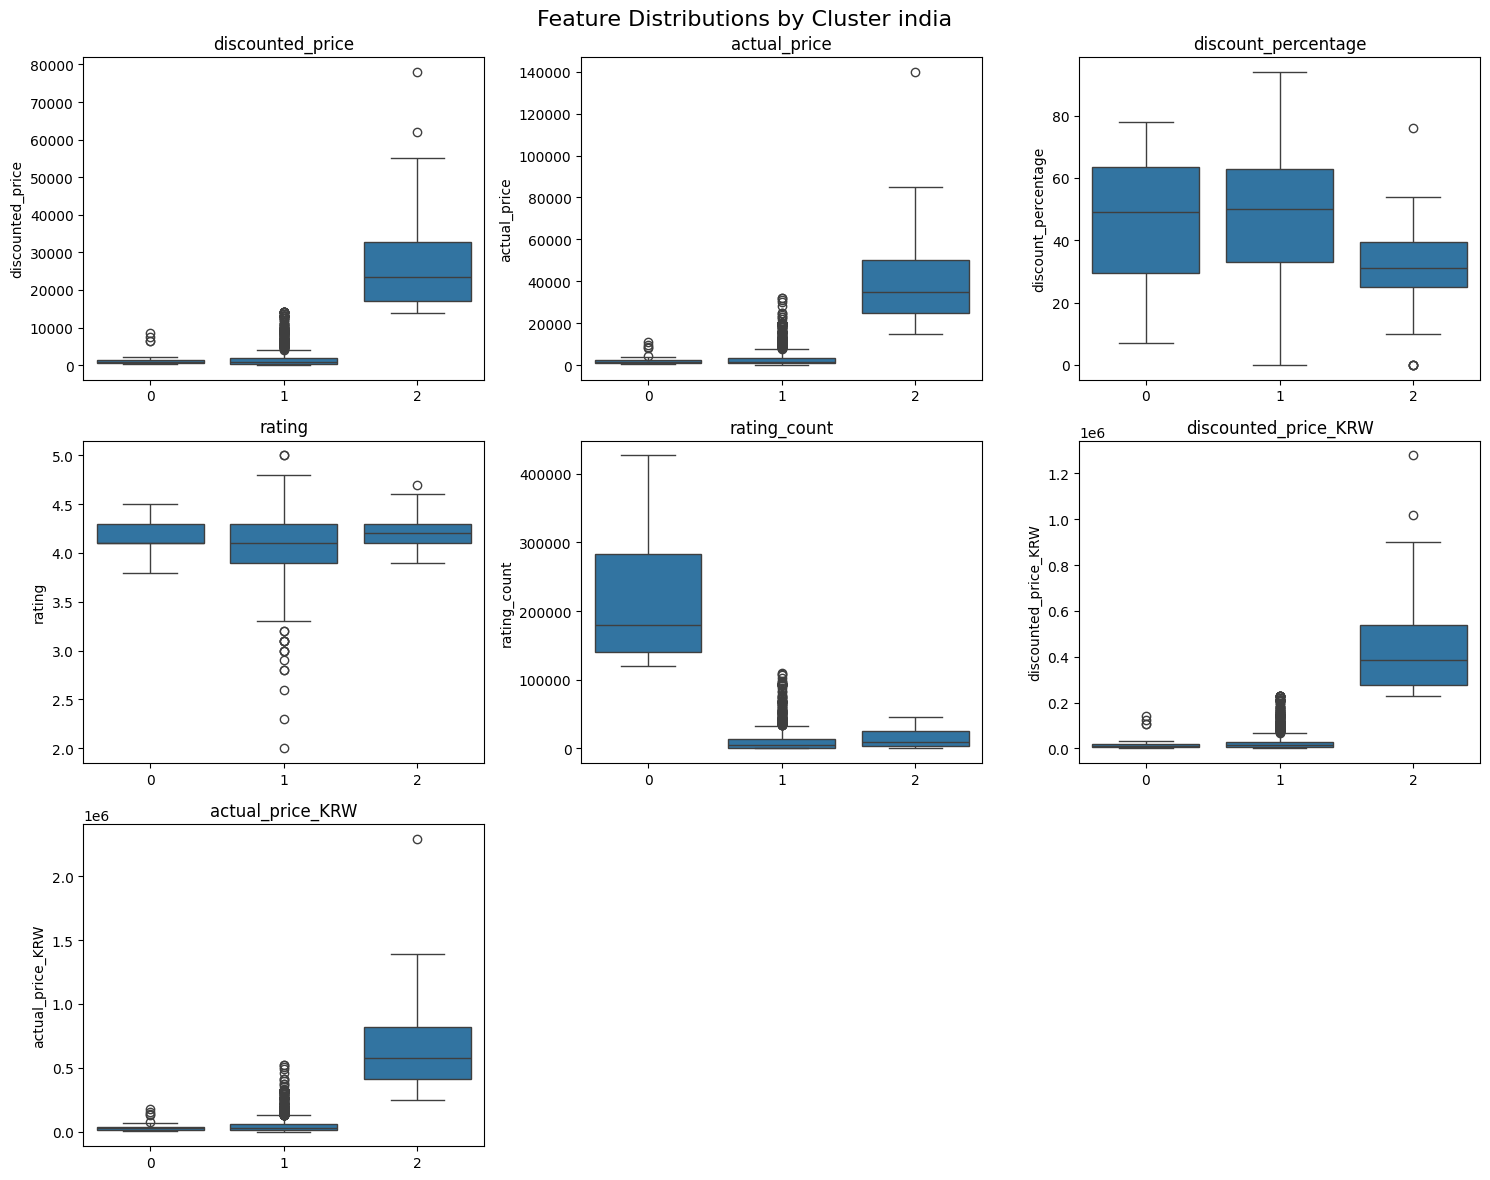

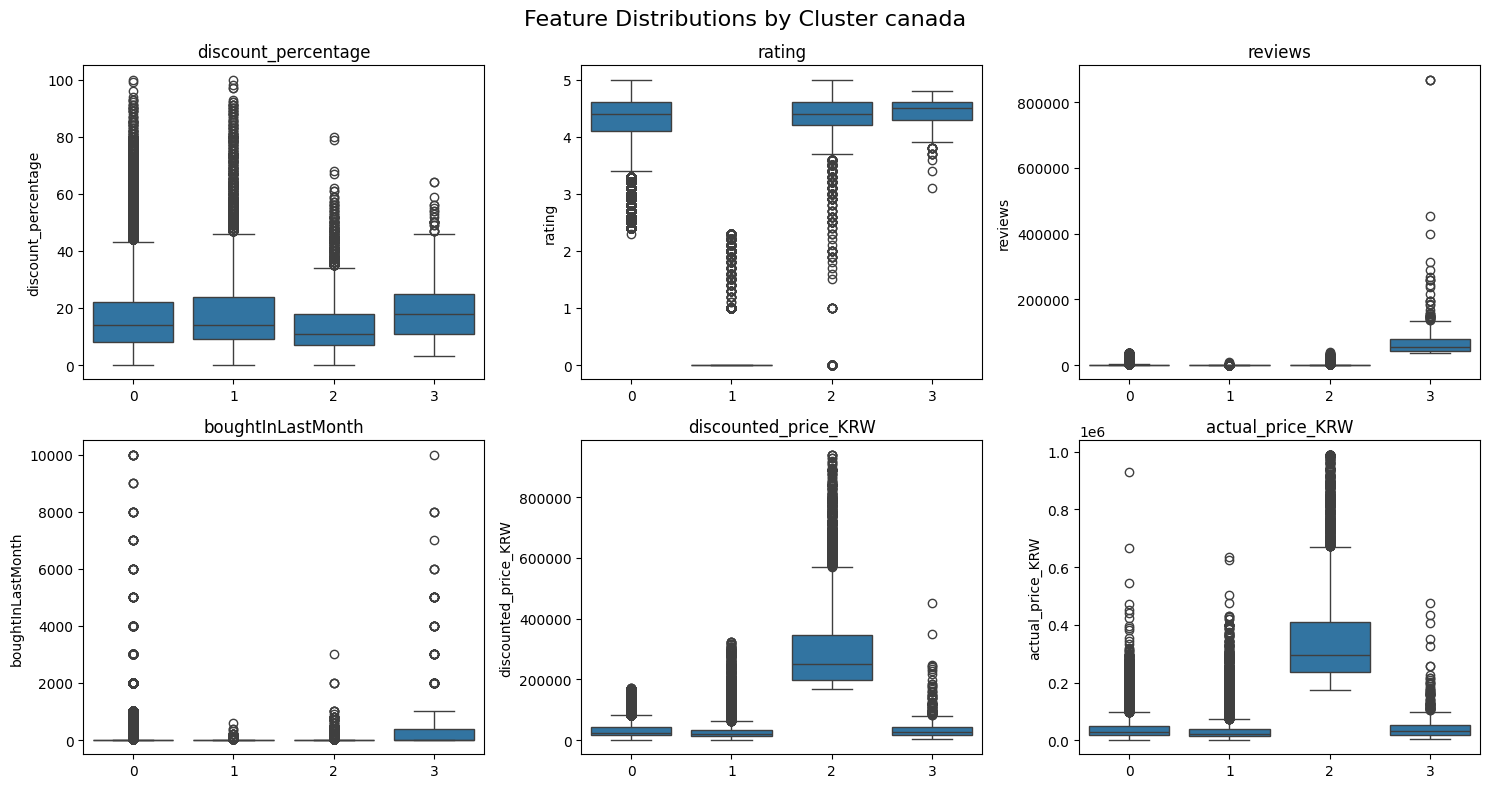

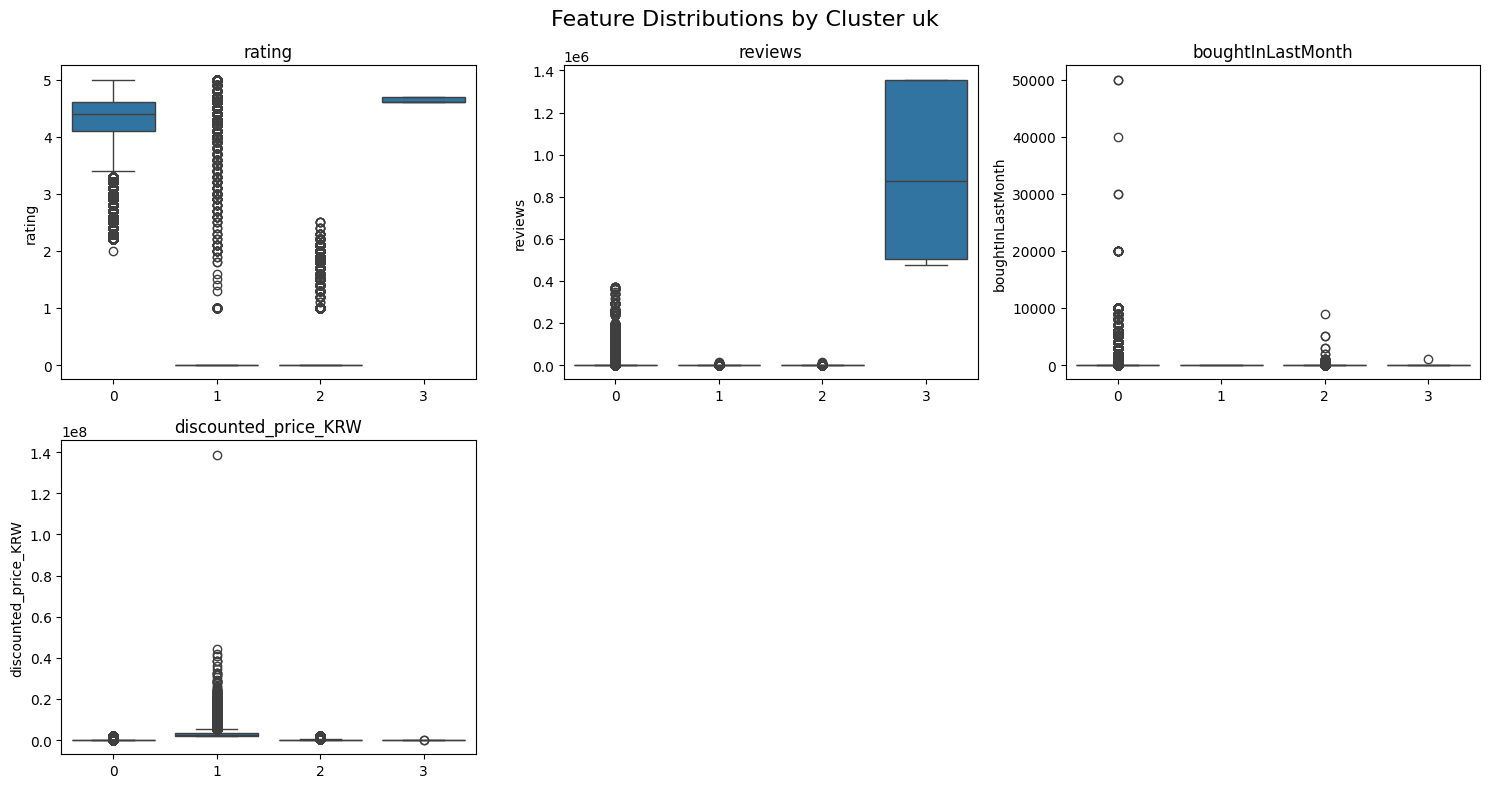

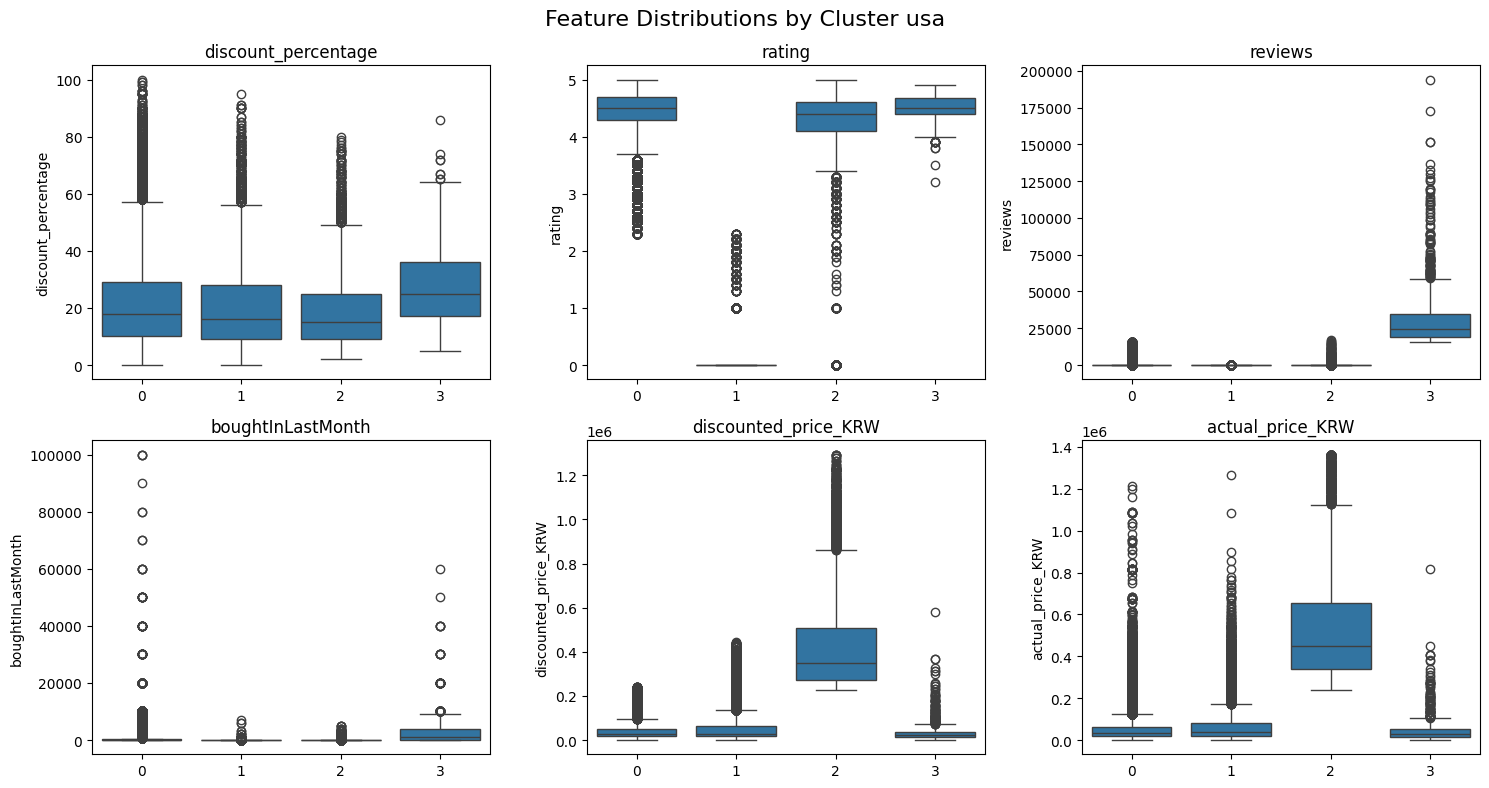

In [519]:
# Usage
plot_feature_distributions(cluster_dfs)

In [520]:
canada_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 166649 entries, 2 to 1982345
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   product_id            166649 non-null  object 
 1   product_name          166649 non-null  object 
 2   category              166649 non-null  object 
 3   discount_percentage   166649 non-null  int64  
 4   rating                166649 non-null  float64
 5   reviews               166649 non-null  int64  
 6   img_link              166649 non-null  object 
 7   product_link          166649 non-null  object 
 8   isBestSeller          166649 non-null  bool   
 9   boughtInLastMonth     166649 non-null  int64  
 10  discounted_price_KRW  166649 non-null  int64  
 11  actual_price_KRW      166649 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 15.4+ MB


/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].astype('category')
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].cat.remove_unused_categories()


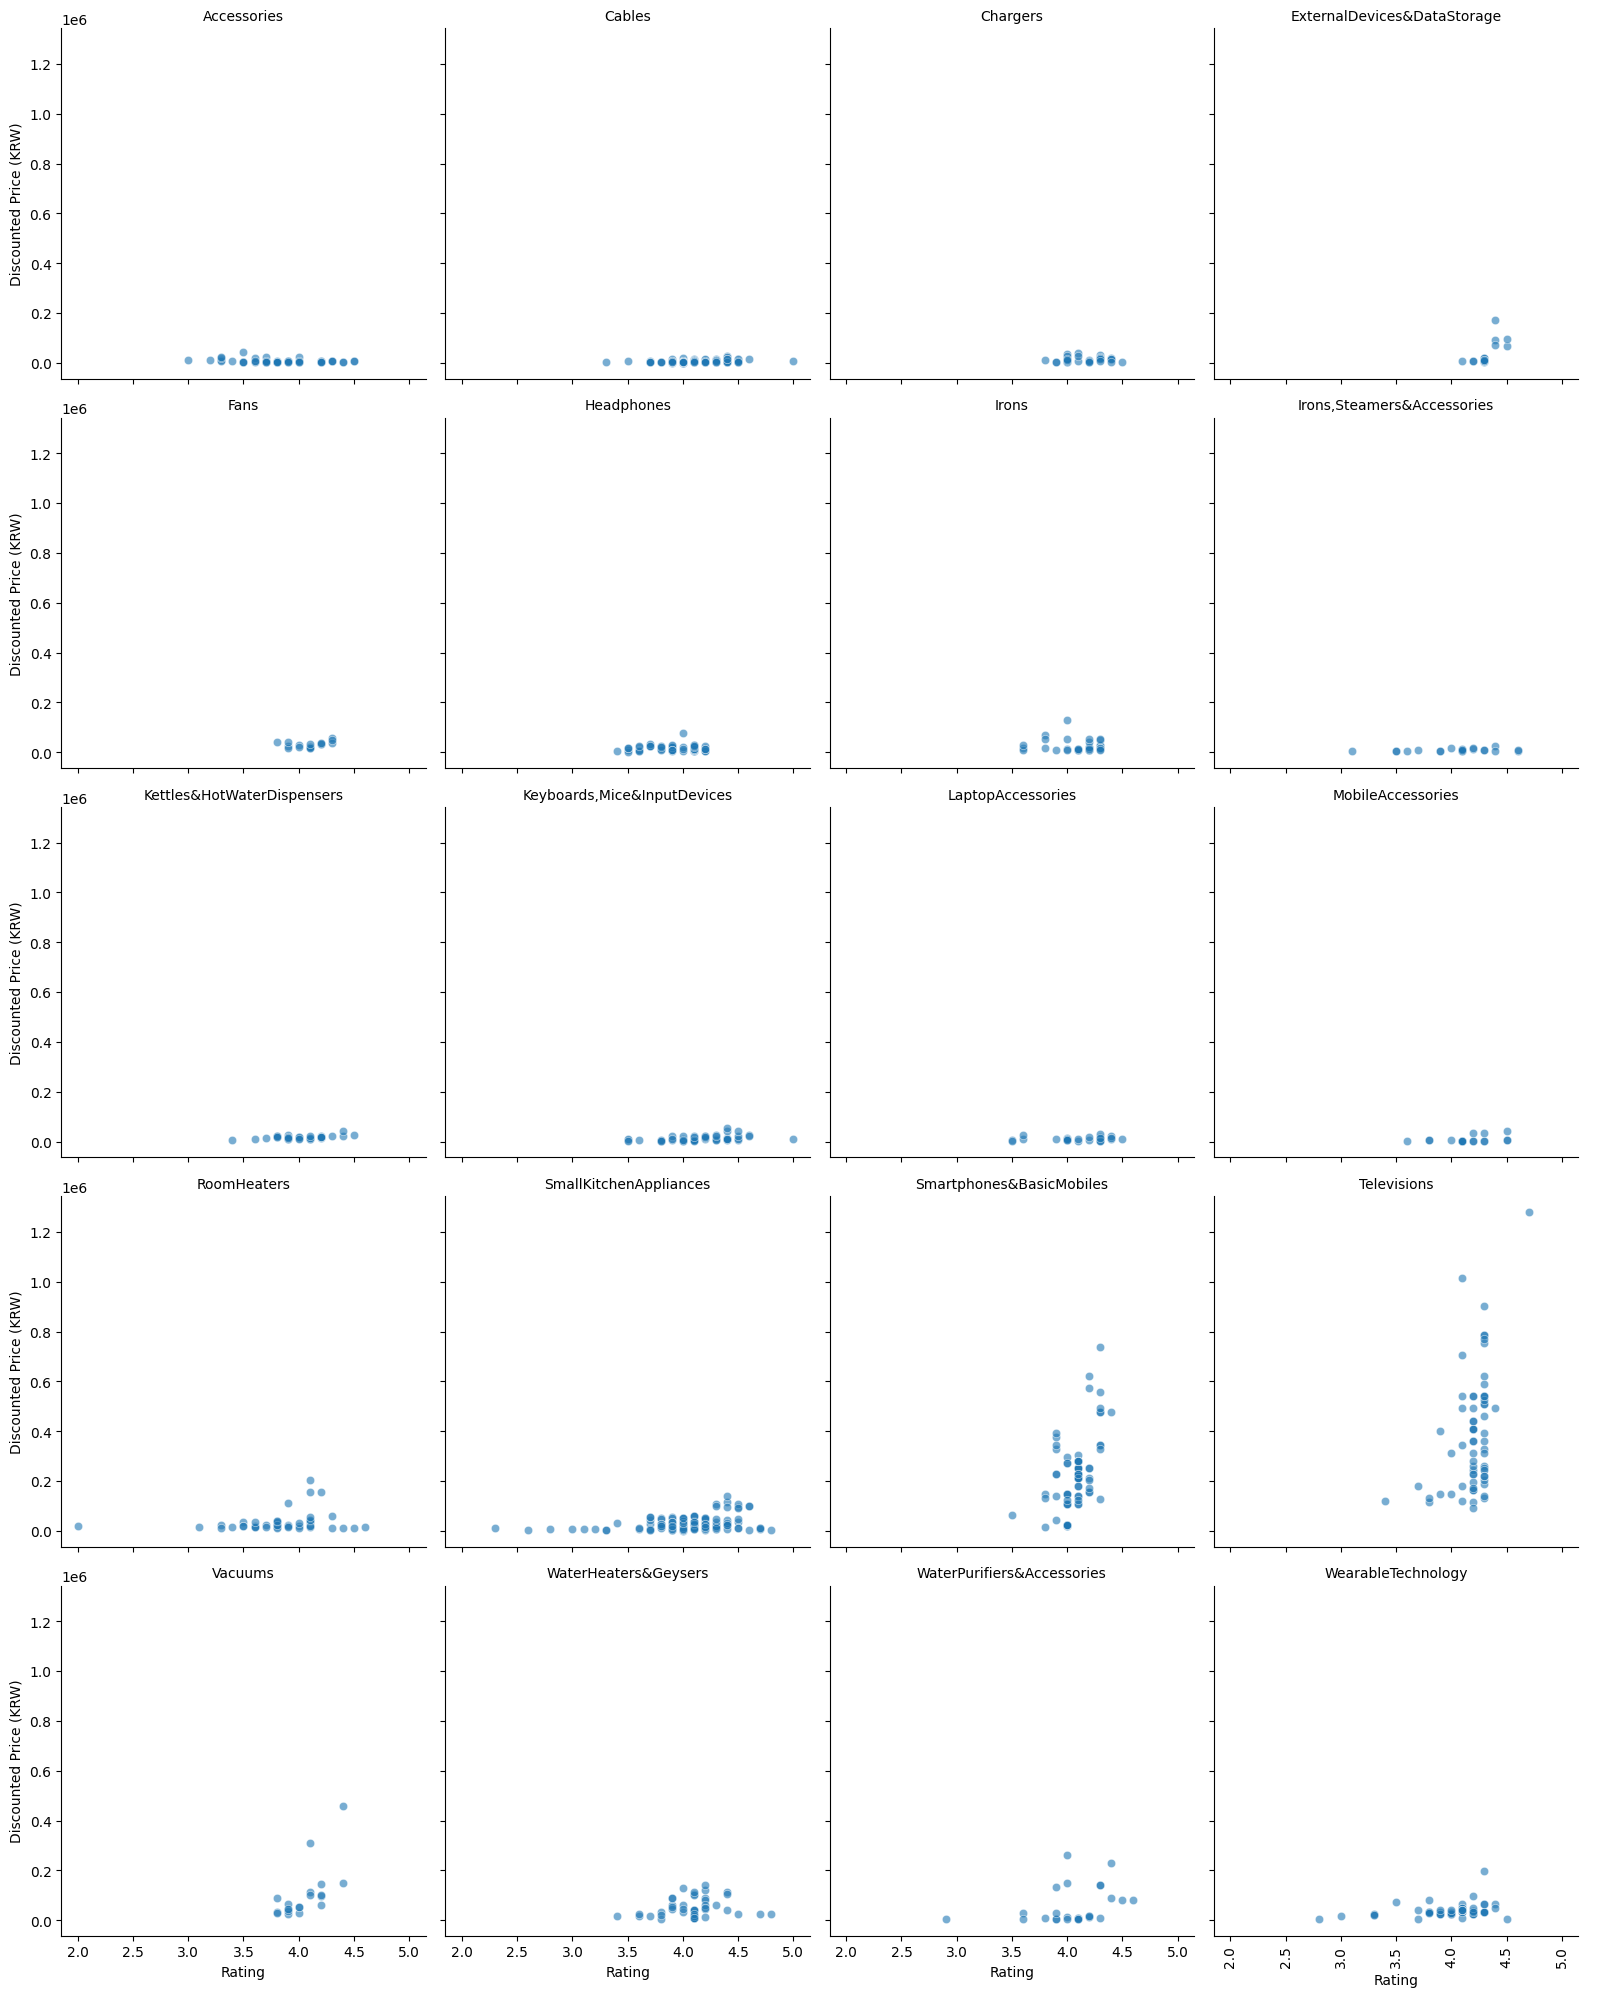

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].astype('category')
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].cat.remove_unused_categories()


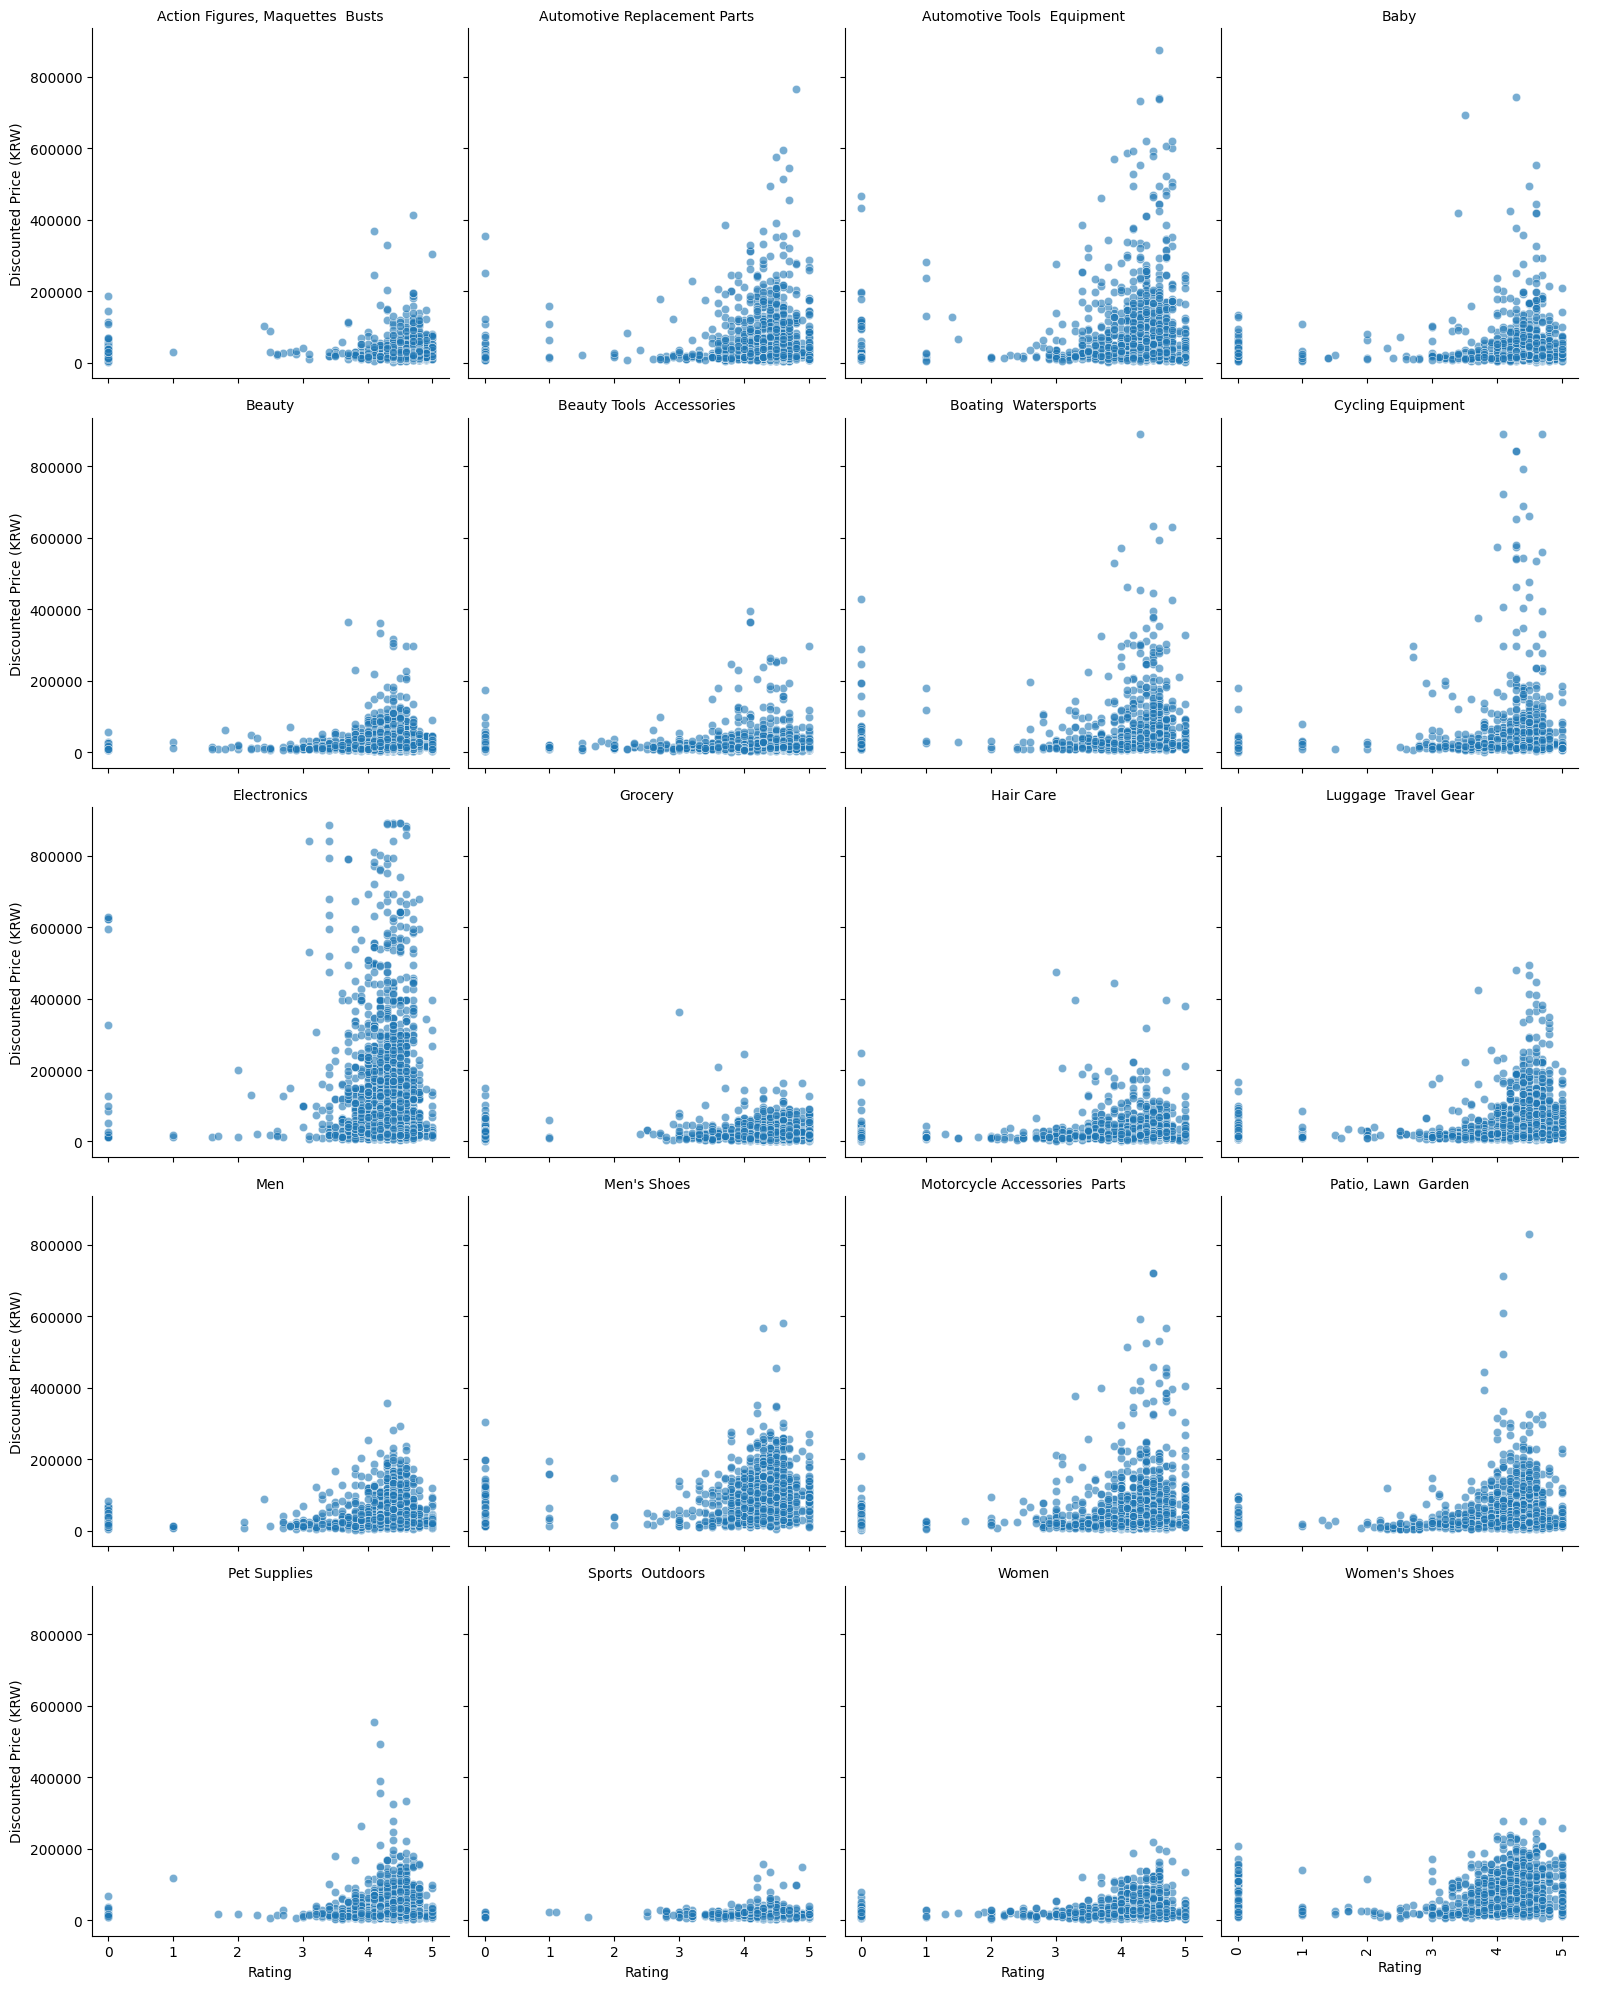

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].astype('category')
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].cat.remove_unused_categories()


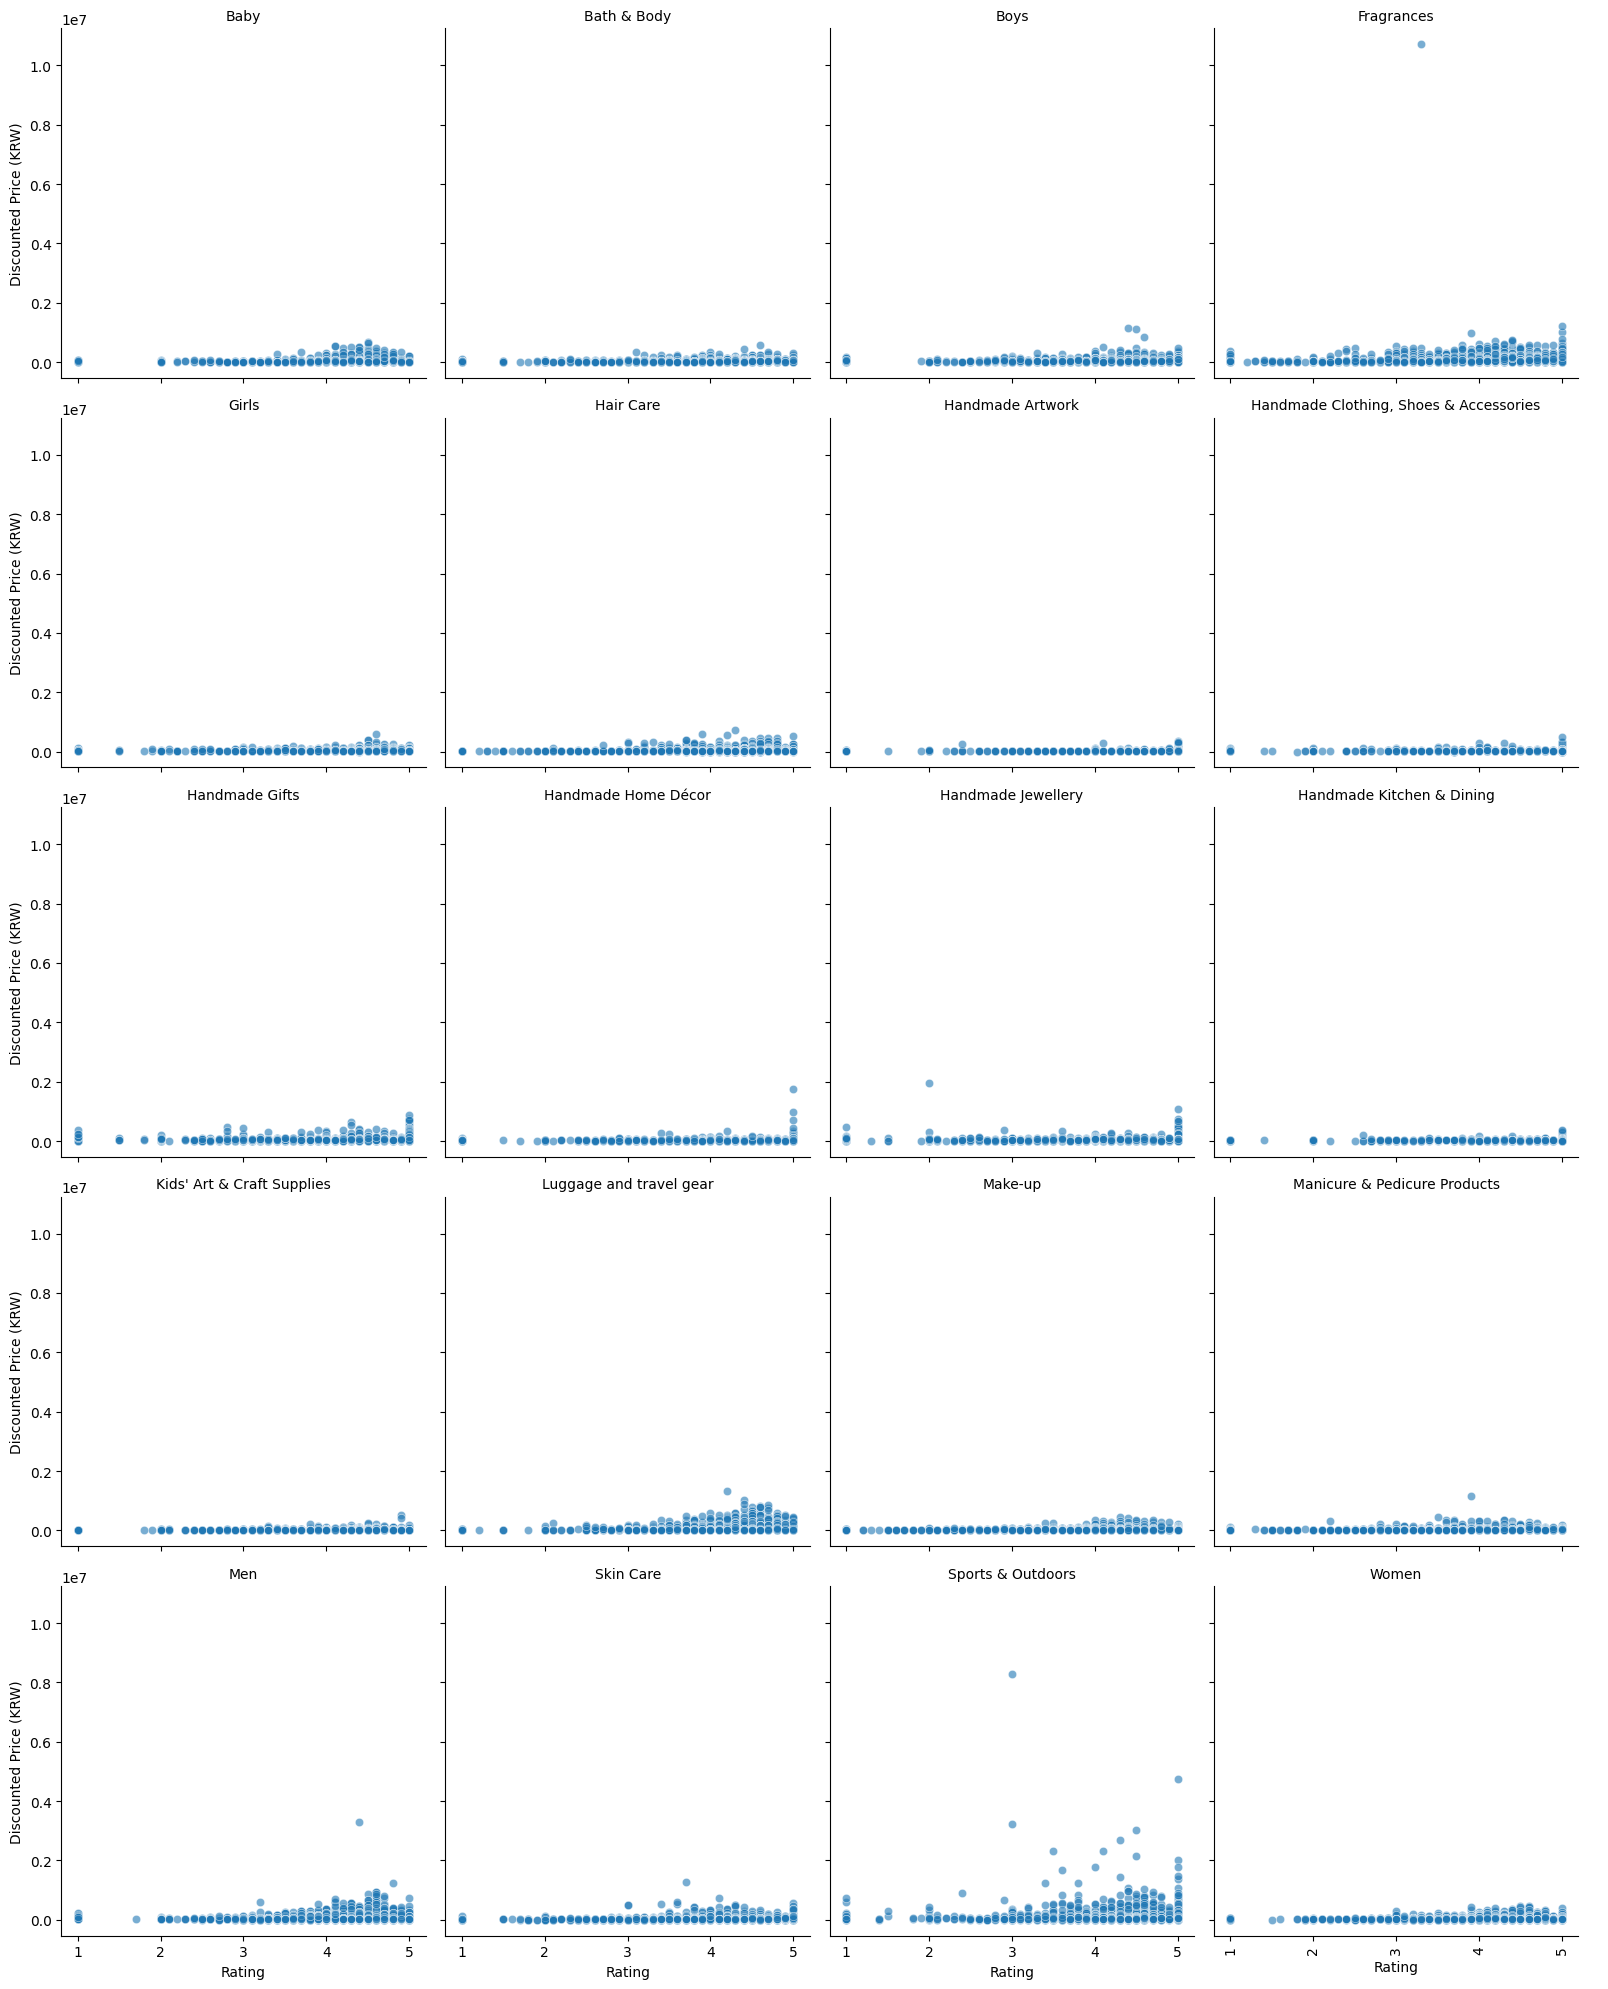

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].astype('category')
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/2843114882.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_category_df['category'] = top_category_df['category'].cat.remove_unused_categories()


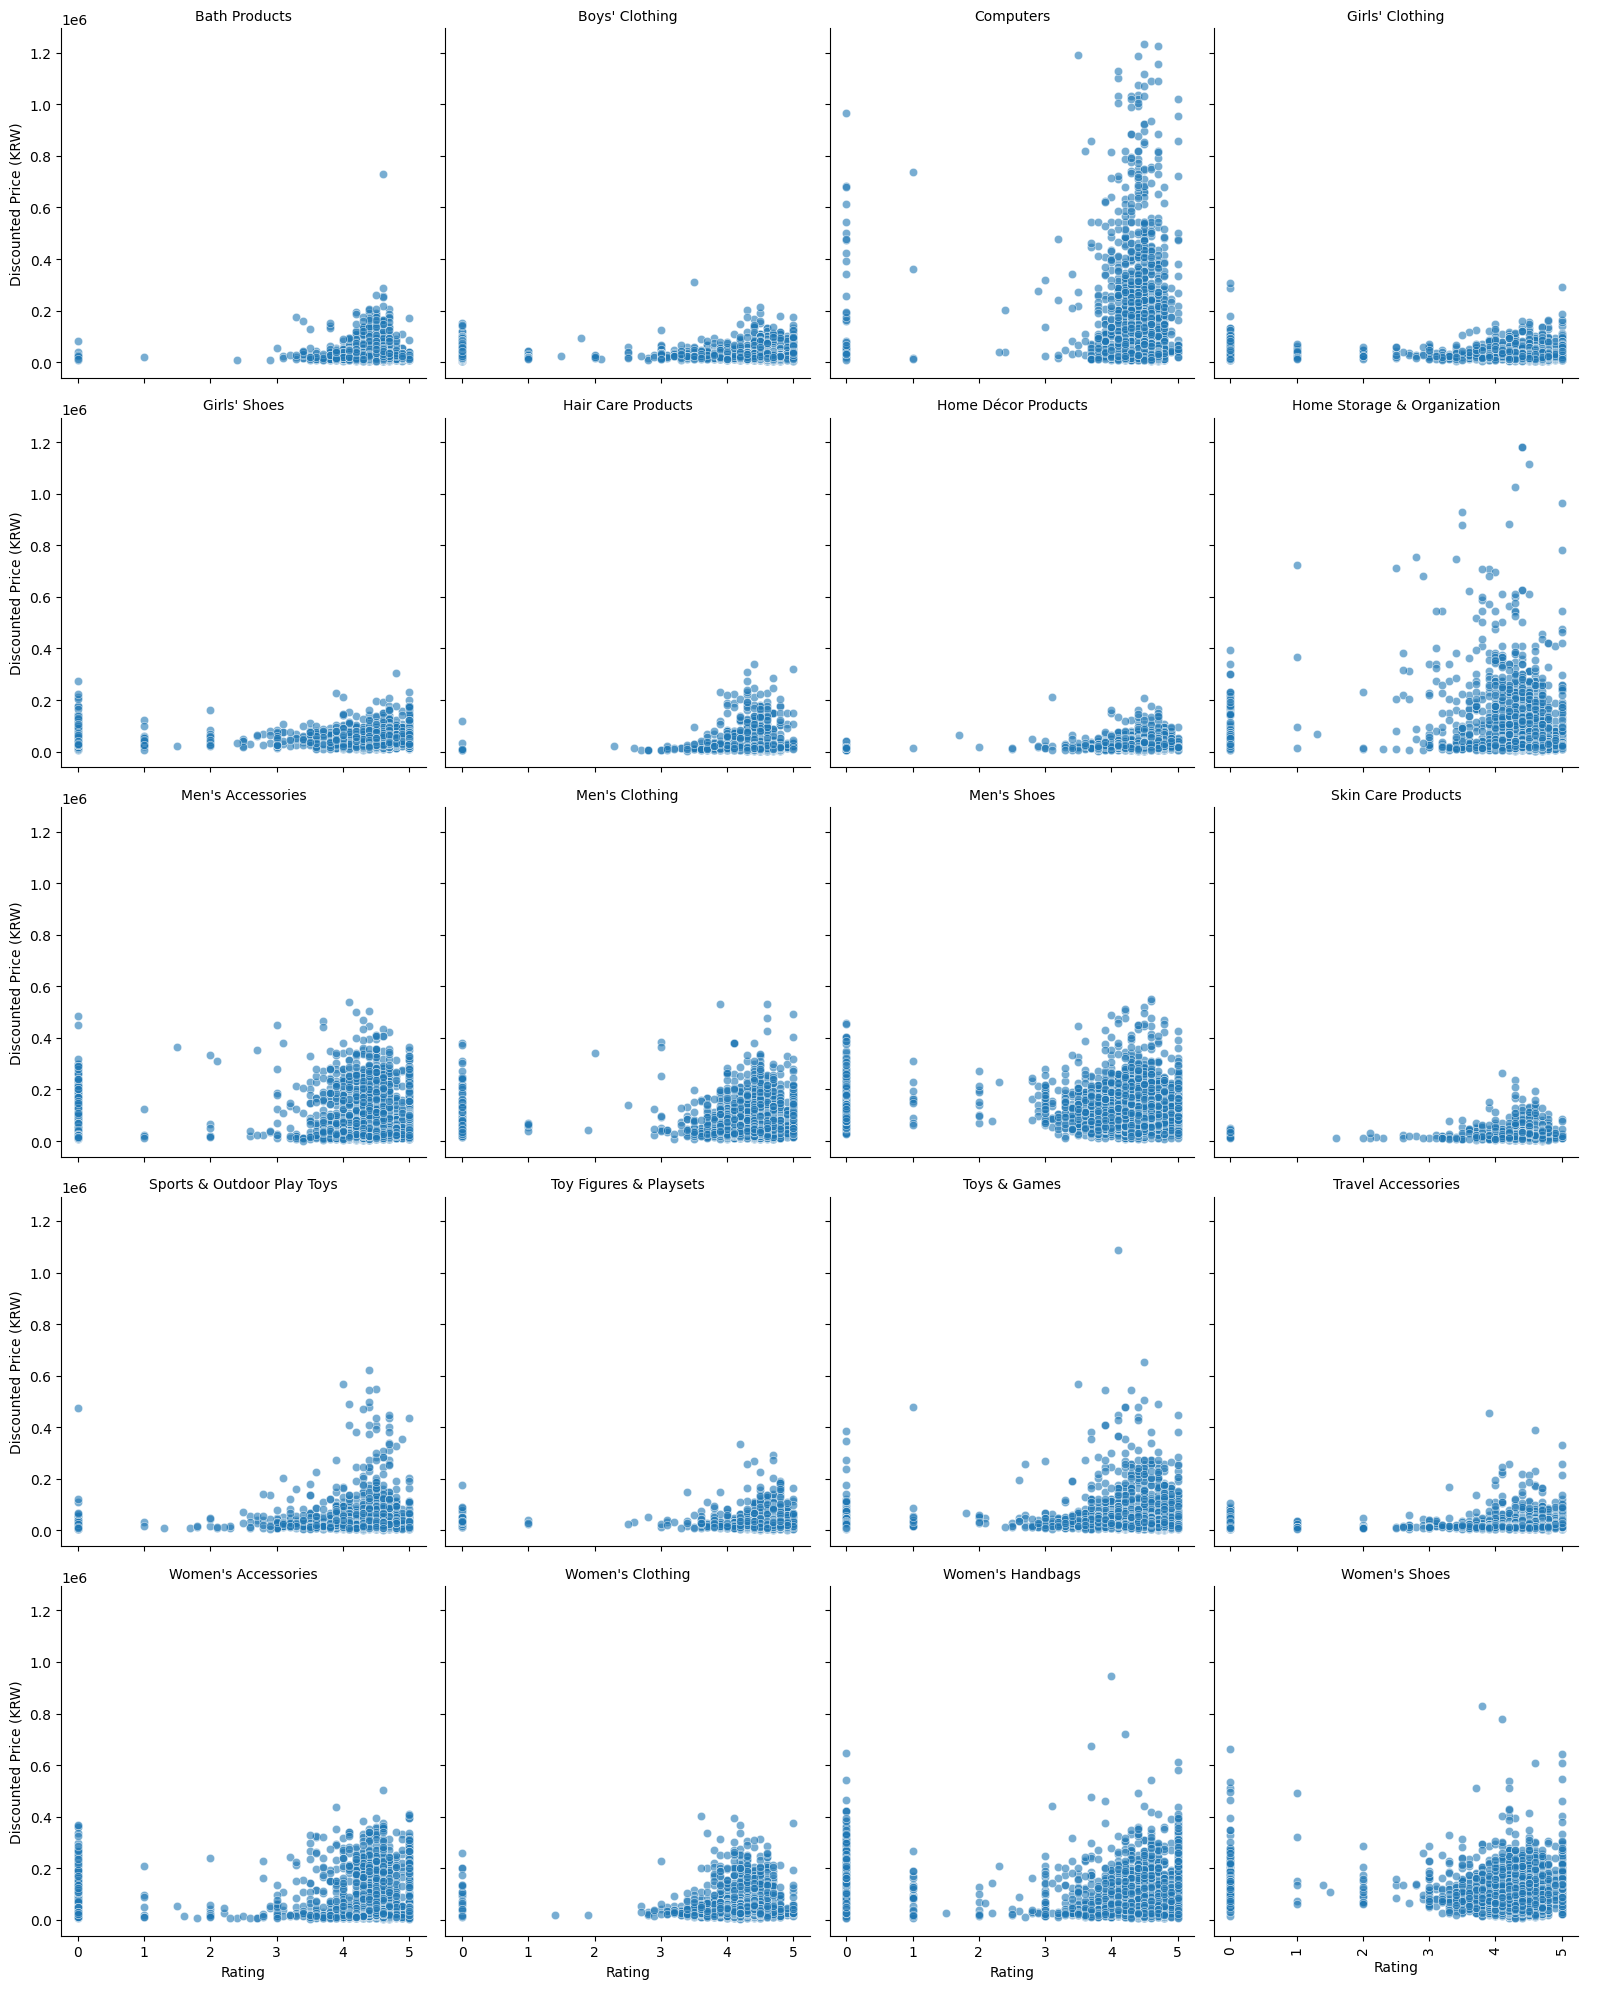

In [521]:
for i, df in enumerate(cluster_dfs):
    # Select the top N categories by frequency
    top_n = 20  # Adjust as needed
    top_categories = df['category'].value_counts().index[:top_n]
    if i == 2:
        df = df.query('rating != 0')
        filtered_df = df[df['category'] == 'Sports & Outdoors']
        max_price_index = filtered_df['discounted_price_KRW'].idxmax()
        df = df.drop(max_price_index)

    # Filter the dataframe to only include these top categories
    top_category_df = df[df['category'].isin(top_categories)]

    # Convert 'category' column to category dtype if it's not already
    if top_category_df['category'].dtype != 'category':
        top_category_df['category'] = top_category_df['category'].astype('category')

    # Reset the categorical levels to remove unused categories
    top_category_df['category'] = top_category_df['category'].cat.remove_unused_categories()

    # Create a FacetGrid to plot the relationship between rating and discounted_price_KRW for each category
    g = sns.FacetGrid(top_category_df, col="category", col_wrap=4, height=4)

    g.map_dataframe(sns.scatterplot, "rating", "discounted_price_KRW", alpha=0.6)

    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Rating", "Discounted Price (KRW)")
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    g.add_legend()
    plt.show()


In [522]:
df = canada_df[canada_df['category'] == 'Makeup']

In [523]:
df.head()

product_id                                       product_name  \
392981  B0C8SZCCQD  Color Changing Blush Oil Liquid Blush Oil for ...   
392983  B099FCLZXJ  Foundation Brush, Cream Contour Brush by ENZO ...   
392985  B09YXW785Q  GAQQI DIY Lashes Clusters 120 PCS C Curl Indiv...   
392988  B08GKQPLGK  Hotrose Full 177 Color Eyeshadow Palette Blush...   
392994  B08HNYDTLG  L'Oreal Paris Le Color Gloss, One Step Toning ...   

       category  discount_percentage  rating  reviews  \
392981   Makeup                    9     2.0        3   
392983   Makeup                   20     4.4      591   
392985   Makeup                   17     4.0       31   
392988   Makeup                   10     4.3     1252   
392994   Makeup                   25     3.9    10732   

                                                 img_link  \
392981  https://m.media-amazon.com/images/I/51vz+DTwba...   
392983  https://m.media-amazon.com/images/I/51ahQuHVAO...   
392985  https://m.media-amazon.com/images/I/91wUBS1H6V...   
392988  https://m.media-amazon.com/images/I/61KfTyURIo...   
392994  https://m.media-amazon.com/images/I/71KD3eRyqF...   

                               product_link  isBestSeller  boughtInLastMonth  \
392981  https://www.amazon.ca/dp/B0C8SZCCQD         False                  0   
392983  https://www.amazon.ca/dp/B099FCLZXJ         False                  0   
392985  https://www.amazon.ca/dp/B09YXW785Q         False                  0   
392988  https://www.amazon.ca/dp/B08GKQPLGK         False                100   
392994  https://www.amazon.ca/dp/B08HNYDTLG         False                 50   

        discounted_price_KRW  actual_price_KRW  
392981                 13455             14841  
392983                 19009             23762  
392985                 18801             22762  
392988                 34732             38594  
392994                 14841             19792

In [524]:
import numpy as np

def check(df):
# 1. 가격 구간 생성 q개 구간)
# df['price_bin'] = pd.qcut(df['discounted_price_KRW'], q=10, labels=[f'Bin {i+1}' for i in range(10)]) # 10개
    df['price_bin'] = pd.qcut(np.log1p(df['discounted_price_KRW']), q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']) # 5개

    # 2. 가격 구간별 성과 계산
    performance = df.groupby('price_bin').agg({
        'discounted_price_KRW': ['mean', 'std'],
        'rating': ['mean', 'std'],
        'reviews': ['mean', 'std']
    })

    # 3. 상관관계 분석
    correlation = df[['discounted_price_KRW', 'rating', 'reviews']].corr()

    # 4. 카테고리별 분석 준비
    category_performance = df.groupby(['category', 'price_bin']).agg({
        'rating': 'mean',
        'reviews': 'mean'
    }).reset_index()

    # 데이터 시각화
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # 1. 가격 구간별 평균 평점 및 리뷰 수 (오차 막대 포함)
    sns.barplot(x='price_bin', y='rating', data=df, ax=axes[0], capsize=.2, palette='viridis')
    axes[0].set_title('Average Rating by Price Bin')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylim(0, 5)  # Adjust y-axis for better visibility of differences

    sns.barplot(x='price_bin', y='reviews', data=df, ax=axes[1], capsize=.2, palette='viridis')
    axes[1].set_title('Average Review Count by Price Bin')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_yscale('log')  # 로그 스케일 적용

    # # 2. 히트맵: 가격, 평점, 리뷰 수의 상관관계
    # sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1,0])
    # axes[1,0].set_title('Correlation Heatmap')

    # # 3. 카테고리별 가격-평점 관계
    # for category in df['category'].unique():
    #     category_data = category_performance[category_performance['category'] == category]
    #     axes[1,1].plot(category_data['price_bin'], category_data['rating'], label=category)

    # axes[1,1].set_title('Average Rating by Price Bin for Each Category')
    # axes[1,1].legend(title='Category')
    # axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
    # axes[1,1].set_ylim(3.5, 4.5)  # Adjust y-axis for better visibility of differences

    plt.tight_layout()
    plt.show()

    # 추가 분석 결과 출력
    print("Price Bin Performance:")
    print(performance.round(2))

    print("\nCorrelation between Price, Rating, and Review Count:")
    print(correlation.round(2))

    # 가격 구간별 상위 아이템 출력
    for bin in performance.index:
        print(f"\nTop 3 Items in {bin}:")
        top_items = df[df['price_bin'] == bin].groupby('category').agg({
            'discounted_price_KRW': 'mean',
            'rating': 'mean',
            'reviews': 'mean'
        }).sort_values('reviews', ascending=False).head(3).round(2)
        print(top_items)

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_bin'] = pd.qcut(np.log1p(df['discounted_price_KRW']), q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']) # 5개
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_bin', y='rating', data=df, ax=axes[0], capsize=.2, palette='viridis')
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:30: UserWarning: FixedFormatter should only be used together wi

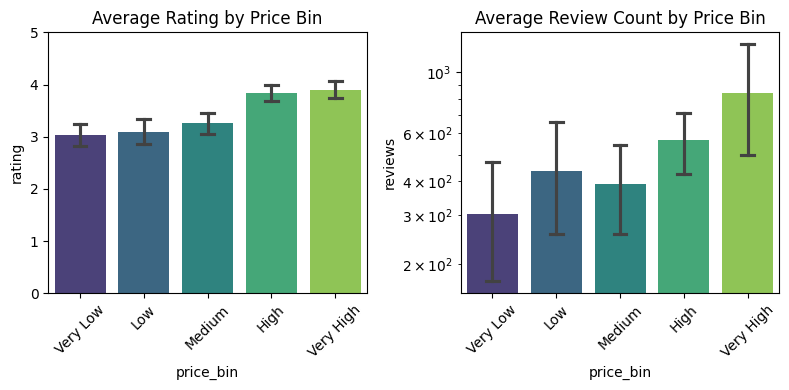

Price Bin Performance:
          discounted_price_KRW           rating       reviews         
                          mean       std   mean   std    mean      std
price_bin                                                             
Very Low               8230.22   1776.25   3.04  1.72  302.74  1345.40
Low                   11320.64    576.87   3.09  1.69  435.48  1382.51
Medium                13953.37   1150.71   3.26  1.64  389.48  1181.44
High                  19387.59   1993.32   3.84  1.17  563.26  1114.65
Very High             42649.84  22754.46   3.90  1.28  840.24  3087.20

Correlation between Price, Rating, and Review Count:
                      discounted_price_KRW  rating  reviews
discounted_price_KRW                  1.00    0.15     0.05
rating                                0.15    1.00     0.15
reviews                               0.05    0.15     1.00

Top 3 Items in Very Low:
          discounted_price_KRW  rating  reviews
category                                 

In [525]:
df = canada_df[canada_df['category'] == 'Makeup']
check(df)

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_bin'] = pd.qcut(np.log1p(df['discounted_price_KRW']), q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']) # 5개
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_bin', y='rating', data=df, ax=axes[0], capsize=.2, palette='viridis')
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:30: UserWarning: FixedFormatter should only be used together wi

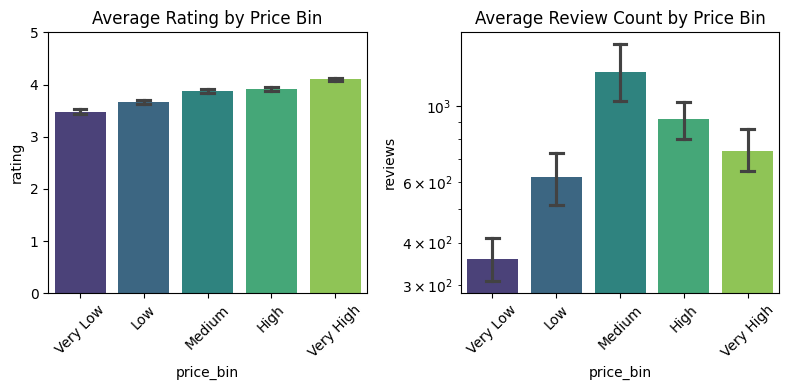

Price Bin Performance:
          discounted_price_KRW           rating        reviews         
                          mean       std   mean   std     mean      std
price_bin                                                              
Very Low               6256.83   1251.40   3.48  1.49   358.58  1700.91
Low                    9561.68    885.01   3.66  1.39   620.03  3449.29
Medium                13141.54   1266.75   3.87  1.18  1257.92  7522.80
High                  19661.28   3191.23   3.91  1.17   915.38  3449.74
Very High             48326.92  30124.74   4.10  0.99   742.56  3332.51

Correlation between Price, Rating, and Review Count:
                      discounted_price_KRW  rating  reviews
discounted_price_KRW                  1.00    0.11    -0.00
rating                                0.11    1.00     0.07
reviews                              -0.00    0.07     1.00

Top 3 Items in Very Low:
          discounted_price_KRW  rating  reviews
category                         

In [526]:
df = uk_df[uk_df['category'] == 'Make-up']
check(df)

/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_bin'] = pd.qcut(np.log1p(df['discounted_price_KRW']), q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']) # 5개
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_bin', y='rating', data=df, ax=axes[0], capsize=.2, palette='viridis')
/var/folders/7y/sc8hkqqj2b78cbbjbty9xcx40000gn/T/ipykernel_904/3214945904.py:30: UserWarning: FixedFormatter should only be used together wi

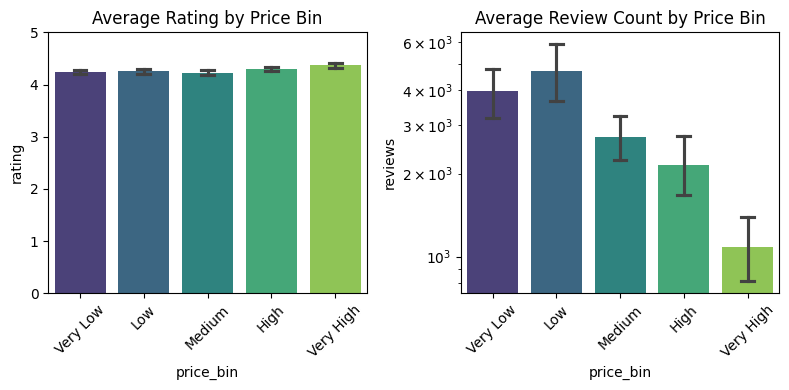

Price Bin Performance:
          discounted_price_KRW           rating        reviews          
                          mean       std   mean   std     mean       std
price_bin                                                               
Very Low               7006.04   1582.95   4.24  0.52  3975.04  10276.31
Low                   10830.01   1016.91   4.25  0.59  4708.46  15014.81
Medium                13678.67    722.95   4.23  0.52  2718.11   5404.89
High                  20587.89   3244.98   4.30  0.47  2138.65   6538.20
Very High             39528.72  14540.37   4.37  0.58  1082.76   3709.05

Correlation between Price, Rating, and Review Count:
                      discounted_price_KRW  rating  reviews
discounted_price_KRW                  1.00    0.06    -0.12
rating                                0.06    1.00     0.06
reviews                              -0.12    0.06     1.00

Top 3 Items in Very Low:
          discounted_price_KRW  rating  reviews
category                 

In [527]:
df = usa_df[usa_df['category'] == 'Makeup']
check(df)

In [528]:
countries = ['India', 'Canada', 'UK', 'USA']

for n, i in enumerate(cluster_dfs):
    # print(f'{countries[n]}')
    i = i.groupby('cluster').size()
    display(i)

cluster
0      40
1    1227
2      86
dtype: int64

cluster
0    134474
1      9100
2      7133
3       840
dtype: int64

cluster
0    870370
1     17275
2    482709
3        35
dtype: int64

cluster
0    294672
1     13748
2     10142
3      1138
dtype: int64